# ***Supervised learning using RGB image data***
#### Author(s): Peng
#### Last update: 11-28-2022

In [1]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchinfo import summary

import pandas as pd
import copy
import os
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from PIL import Image
from IPython.display import clear_output

In [76]:
# Define global variables for the notebook
##################################
# Define if GPU is used
use_cuda = True
if use_cuda:
    print('Using GPU')

# Main working directory containing all the output files in this notebook
# Bald Mountain Top Pit 2021
# Gold Bar Pick Pit 2021
mine_site = 'GB'

if mine_site == 'BM':
    main_dir = os.path.join(os.getcwd(), r'Bald Mountain Top Pit 2021')
elif mine_site == 'GB':
    main_dir = os.path.join(os.getcwd(), r'Gold Bar Pick Pit 2021')
    
if os.path.exists(main_dir):
    print('Current output directory is: ', main_dir)
else:
    raise Exception('Directory DNE')
##################################

Using GPU
Current output directory is:  D:\MASC Big Files\Data Processing\Deep Learning\Supervised Learning\Gold Bar Pick Pit 2021


## Data Loading

In [3]:
def data_load(df = None, lf = None, verbose = True):
    """
    Description:
        Load data and/or labels.
        
    Args:
        df: File containing data (str)
        lf: file containing labels (str)
        verbose: Print out shapes (bool)
    
    Outputs:
        data: Torch tensor data 
        labels: None or torch tensor labels 
    """
    
    # Load data
    if df is not None:
        data = torch.load(df)
        if data.shape[1] != 3:
            data = torch.permute(data, (0, 3, 1, 2)) # [N, C, H, W] channel first
        if verbose:
            print('Data shape:', data.shape)
    else:
        data = None
    
    # Load labels 
    if lf is not None:
        labels = torch.load(lf)
        if labels.dim() > 2:
            labels = torch.permute(labels, (0, 3, 1, 2)) # [N, C, H, W] channel first
        if verbose:
            print('Labels shape:', labels.shape)
    else:
        labels = None
            
    if data is None and labels is None:
        raise Exception("Data or labels required")
    else:
        return data, labels    

## Data Creation

In [3]:
def data_create(data_dir, label_dir, req_dim, convert, save = False):
    """
    Description: 
        Data preparation:
            1. Load image tiles and labels
            2. Remove undesired dimensions (optionally other tiles such as edge tiles)
            3. Assign a label to pixels that do not have one (said pixels should have a placeholder value of zero)
            4. Optional: save data and labels
    
    Args:
        data_dir: Directory of the data (str)
        label_dir: Directory of the labels corresponding to the data (str)
        req_dim: Required tile dimension (int)
        convert: If label 0 should be converted into another label (bool)
        save: Save data (bool)
        
    Outputs:
        None
        
    """
    
    # Import Image tiles 
    data_dict = {}
    label_dict = {}
    i = 0    
    unlab_count = 0
    random.seed(0)
    
    for dat_name, lab_name in zip(os.listdir(data_dir), os.listdir(label_dir)):
        # Ensure tile indices are the same 
        dat_indx = int(dat_name.split('.')[-2])
        lab_indx = int(lab_name.split('.')[-2])
        assert dat_indx == lab_indx, 'Indices mismatch {} data with {} label'.format(dat_indx, lab_indx)
        
        with Image.open(os.path.join(data_dir, dat_name)) as im: 
            imarray = np.array(im) # [H, W, 3]
            if imarray.shape == (req_dim, req_dim, 3):              
                data_dict[dat_indx] = imarray # Store data in a dict: Key = tile index, item = image tile array
                
        with Image.open(os.path.join(label_dir, lab_name)) as lab: 
            labarray = np.expand_dims(np.array(lab)[..., 0], axis = -1) # [H, W, 1] Only get first channel (all the same)
            if labarray.shape == (req_dim, req_dim, 1):
                # Randomly assign a label from unique labels present in the tile to unlabelled pixels
                if convert:                
                    labs_in_tile = np.unique(labarray)
                    if 0 in labs_in_tile:
                        labarray = np.where( labarray == 0, random.choice(list(labs_in_tile[labs_in_tile > 0])), labarray) 
                        assert 0 not in labarray, 'Unlabelled pixel still present in {}'.format(lab_name)
                        unlab_count += 1
                label_dict[lab_indx] = labarray              
        
        i += 1
        if i % 1000 == 0:
            print('{} images processed...'.format(i)) # Track progress
    
    # Ensure the same number of tiles are stored
    assert len(data_dict) == len(label_dict), 'Dicts are different length {} vs {}'.format(len(data_dict), len(label_dict)) 
    print('Total of {} images stored'.format(len(data_dict)))
    if convert:
        print('Total number of unlabelled pixels: ', unlab_count)
    print()
    
    ###############################
    # Code for further tile removal (to be written)
    ###############################
    
    # Save data as torch tensor
    if save:
        torch.save(torch.tensor( np.array( list(data_dict.keys()) ) ), 
                   os.path.join(main_dir, 'ind_tensors_{}.pt'.format(req_dim)))
        torch.save(torch.tensor( np.array( list(data_dict.values()) ) ).float(), 
                   os.path.join(main_dir, 'data_tensors_{}.pt'.format(req_dim)))
        torch.save(torch.tensor( np.array( list(label_dict.values()) ) ), 
                   os.path.join(main_dir, 'labels_tensors_{}.pt'.format(req_dim)))
        print('Data saved')    
        print()
    
    print('Data Creation complete')

In [17]:
data_dir = r'D:\MASC Big Files\Data Processing\Deep Learning\Data\Labelled\2021_GB_Pick_96_E_Top'
label_dir = r'D:\MASC Big Files\Data Processing\Deep Learning\Data\Labelled\2021_GB_Pick_96_E_Top_labels'
req_dim = 96
data_create(data_dir, 
            label_dir, 
            req_dim,
            convert = False,
            save = True)

1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
Total of 4410 images stored

Data saved

Data Creation complete


In [16]:
def label_change(data, labels, change, value):
    """
    Description:
        Change class labels and corresponding data by removing or changing them.
        
    Args:
        data: The raw data tensors or file name (torch tensor or str)
        labels: The labels corresponding to each tile or file name (torch tensor or str)
        change: The class label number to be removed/changed (int)
        value: The new value for the class label to be changed (int)
    
    Outputs:
        data: The new data with the specified class label removed (torch tensor)
        labels: The new labels with the specified class label removed (torch tensor)
    
    """
    
    # Load the data
    if type(data) == str:
        data, _ = data_load(data, None, verbose = False) 
        
    # Load the labels
    if type(labels) == str:
        _, labels = data_load(None, labels, verbose = False) 
        
    assert data.shape[0] == labels.shape[0], 'Data and label shapes are different {} vs {}'.format(data.shape[0], 
                                                                                                  labels.shape[0])
    # Remove/change select data and labels corresponding to a specified class
    print('Label classes before: {}'.format(torch.unique(labels)))
    
    if value is None: # Just remove
        mask = torch.where(labels != change)[0] # Mask of indices not containing removed class   
        labels = labels[mask]
        data = data[mask]
    else: # Replace with value
        labels = torch.where(labels == change, torch.tensor(value, dtype = labels.dtype), labels) # match dtype
        
    assert change not in labels, 'Class {} is still in labels'.format(change)
    
    print('Labels after: {}'.format(torch.unique(labels)))
    labels = torch.where(labels > change, labels - 1, labels) # Ensure class labels are sequential starting from 1
    print('Labels after sequencing from 1: {}'.format(torch.unique(labels)))
    
    return data, labels

def tile_label(data_f, label_f, method, change = None, value = None, save = True):
    """
    Description:
        Convert pixel-wise labelling to tile-wise labelling for classification
        
    Args:
        data_f: The file name of the raw data tensors (str)
        label_f: The file name of the labels corresponding to each tile (str)
        method: The label conversion method (str)
        change: The class label number to be removed/changed (int)
        value: The new value for the class label to be changed (int)
        save: Save the new labels (bool)
    
    Outputs:
        None
    
    """
    
    # Load labels
    if type(data_f) == str and type(label_f) == str:
        data, labels = data_load(df = os.path.join(main_dir, data_f), 
                             lf = os.path.join(main_dir, label_f), 
                             verbose = False)
    else:
        data, labels = data_f, label_f
    
    # Convert torch tensor to numpy array
    if type(labels) == torch.Tensor:
        labels = labels.numpy() # np arr [N, 1, H, W]
    
    # Assign label to tile
    new_labels = []
    for i in range(labels.shape[0]):        
        if method == 'pixel majority':
            values, count = np.unique(labels[i], return_counts = True) # Get the labels and their count in each tile
            assigned_label = values[np.argmax(count)] # Label with the most pixels as the tile label
            new_labels.append(assigned_label)
    new_labels = torch.tensor(np.expand_dims(np.array(new_labels), axis = -1)) # torch tensor [N, 1]
    
    # Change a certain class from data and labels
    if change is not None:
        data, new_labels = label_change(data, new_labels, change, value)
        if save:
            torch.save(data, 
                       os.path.join(main_dir, data_f)) # Overwrite existing file
    
    # Save new labels    
    if save:
        torch.save( new_labels, os.path.join(main_dir, 'tile_' + label_f) )
    print('tile labels shape: ', new_labels.shape)
    
    return data, new_labels

In [4]:
def data_aug(orig_data, orig_labels, aug_data, aug_labels, dim, num = 0):
    """
    Description:
        Increase the number of samples through data augmentation. 
        Methods: 
            1. tiles of a greater size will be randomly cropped to the desired tile size
    
    Args:
        orig_data: File name of original data (str)
        orig_labels: File name of original labels (str)
        aug_data: File name of the data to be used for augmentation (str)
        aug_labels: File name of the labels of the augmentation data (str)
        dim: The dimension of the crop (int)
        num: Number of randomly cropped tiles created for each input tile (int)
    
    Outputs:
        o_data: Additional augmented data (Pytorch tensor)
        o_labels: Labels associated with augmented data (Pytorch tensor)
        
    """

    # Load original and larger tile size data to be used to increase sample count
    o_data, o_labels = data_load(df = os.path.join(main_dir, orig_data), lf = os.path.join(main_dir, orig_labels))
    a_data, a_labels = data_load(df = os.path.join(main_dir, aug_data), lf = os.path.join(main_dir, aug_labels))      
    
    # Ensure the cropped tile size is smaller than the larger tile size data
    assert dim < a_data.shape[-2], 'The crop dimension needs to be smaller than the tile size'
    
    # Randomly crop from a larger tile size 
    if num > 0:
        print('Randomly cropping {} times'.format(num))
        transform_crop = transforms.RandomCrop(size = (dim, dim))
        for i in range(num):
            cropped = transform_crop(a_data)
            o_data = torch.cat([o_data, cropped], axis = 0) # (N*, C, H, W)
            o_labels = torch.cat([o_labels, a_labels], axis = 0) # (N*,)
    
        print('Augmented data and labels size:', o_data.shape, o_labels.shape)
    
    return o_data, o_labels   

In [18]:
data_file = 'data_tensors_96.pt'
label_file = 'labels_tensors_96.pt'
method = 'pixel majority' # Options: pixel majority
_, __ = tile_label(data_file, 
           label_file, 
           method, 
           change = 1, 
           value = 2)
### Beware of original data and label files being overwritten!!!!

Label classes before: tensor([0, 1, 2, 3, 4, 5], dtype=torch.uint8)
Labels after: tensor([0, 2, 3, 4, 5], dtype=torch.uint8)
Labels after sequencing from 1: tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tile labels shape:  torch.Size([4410, 1])


In [5]:
# Augment data
new_data, new_labels = data_aug(orig_data = 'data_tensors_96.pt',
                                 orig_labels = 'tile_labels_tensors_96.pt',
                                 aug_data = 'data_tensors_256.pt', 
                                 aug_labels = 'tile_labels_tensors_256.pt', 
                                 dim = 96,
                                 num = 6)

Data shape: torch.Size([4410, 3, 96, 96])
Labels shape: torch.Size([4410, 1])
Data shape: torch.Size([611, 3, 256, 256])
Labels shape: torch.Size([611, 1])
Randomly cropping 6 times
Augmented data and labels size: torch.Size([8076, 3, 96, 96]) torch.Size([8076, 1])


In [6]:
# Save augmented data
torch.save(new_data, os.path.join(main_dir, 'data_tensors_96_aug256-6.pt'))
torch.save(new_labels, os.path.join(main_dir, 'tile_labels_tensors_96_aug256-6.pt'))

### Data Subdivision

In [11]:
def tile_split(data_file, label_file, size):
    """
    Description:
        Split existing tile data into smaller ones (Must be of equal sizes) and duplicate labels.
    
    Args:
        data_file: File containing data tensors (str)
        label_file: File containing labels (str)
        size: The size of the new tiles (int)        
    
    Outputs:
        new_data: New data of new size (torch tensor)
        new_labels: New labels of new size (torch tensor)
    """
    
    # Import data and labels
    data, labels = data_load(data_file, label_file)
    assert data.shape[1] == 3, 'Band channel should be dim 1'
    
    # Split data and duplicate labels
    data_A, data_B = torch.split(data, size, dim = -1) # (N, C, H, size)
    data_A1, data_A2 = torch.split(data_A, size, dim = -2) # (N, C, size, size)
    data_B1, data_B2 = torch.split(data_B, size, dim = -2) # (N, C, size, size)
    new_data = torch.cat((data_A1, data_A2, data_B1, data_B2), dim = 0) # (N*2*H/size, C, size, size)
    new_labels = labels.repeat(int(new_data.shape[0]/data.shape[0])) # (N*2*H/size, )
    
    print('New data shape {} and new labels shape {}'.format(new_data.shape, new_labels.shape))
    return new_data, new_labels  

In [18]:
# Split training, validation, and testing data
# This way ensures the same data set is used for its purpose
size = 32 # Change
train, train_labels = tile_split(os.path.join(main_dir, 'train_tensors_64.pt'),
                                 os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'),
                                 size)

val, val_labels = tile_split(os.path.join(main_dir, 'val_tensors_64.pt'),
                             os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'),
                             size)

test, test_labels = tile_split(os.path.join(main_dir, 'test_tensors_64.pt'),
                             os.path.join(main_dir, 'test_tile_labels_tensors_64.pt'),
                             size)

torch.save(train, os.path.join(main_dir, 'train_tensors_{}.pt'.format(size)))
torch.save(train_labels, os.path.join(main_dir, 'train_tile_labels_tensors_{}.pt'.format(size)))
torch.save(val, os.path.join(main_dir, 'val_tensors_{}.pt'.format(size)))
torch.save(val_labels, os.path.join(main_dir, 'val_tile_labels_tensors_{}.pt'.format(size)))
torch.save(val, os.path.join(main_dir, 'test_tensors_{}.pt'.format(size)))
torch.save(val_labels, os.path.join(main_dir, 'test_tile_labels_tensors_{}.pt'.format(size)))

Data shape: torch.Size([7862, 3, 64, 64])
Labels shape: torch.Size([7862])
New data shape torch.Size([31448, 3, 32, 32]) and new labels shape torch.Size([31448])
Data shape: torch.Size([983, 3, 64, 64])
Labels shape: torch.Size([983])
New data shape torch.Size([3932, 3, 32, 32]) and new labels shape torch.Size([3932])
Data shape: torch.Size([983, 3, 64, 64])
Labels shape: torch.Size([983])
New data shape torch.Size([3932, 3, 32, 32]) and new labels shape torch.Size([3932])


### Statistics of entire data set

In [4]:
def stats_plot(data_file, label_file, data_set_type = ''):
    """
    Description:
        Show plots give statistics of a data set.
        
    Args:
        data_file: File name of the data (str)
        label_file: File name of the labels (str)
        data_set_type: Options are - Training, Validation, Testing (str)
    
    Outputs:
        None
    
    """
    
    data, labels = data_load(df = data_file, lf = label_file, verbose = False)
    num_class, class_count = torch.unique(labels, sorted = True, return_counts = True)
    if data_set_type != '':
        data_set_type = ' ' + data_set_type # Add a space at the beginning

    # Number of classes 
    print('Total number of unique classes in data:', len(num_class))

    # Number of samples per class
    for cls in range(len(class_count)):
        print('Class {0}: {1:,} samples ({2:.1f}% of total)'.format(num_class[cls], 
                                                                  class_count[cls], 
                                                                  100*class_count[cls]/sum(class_count)))
    print('Total number of tiles:', labels.shape[0])
    print('\n')

    # Number of pixels and unique classes per sample
    if labels.dim() > 2:    
        cls_in_sample = {}
        for x in num_class:
            cls_in_sample[x.item()] = 0

        for i in range(labels.reshape((labels.shape[0], -1)).shape[0]):
            cls_in_sample[ len(np.unique(labels.reshape((labels.shape[0], -1))[i])) ] += 1 

        for key in cls_in_sample.keys():
            print('{} class(es) per sample: {:,} ({:.1f}%)'.format(key, 
                                                                   cls_in_sample[key], 
                                                                   100*cls_in_sample[key]/sum(cls_in_sample.values())))
        print('Total number of pixels: {:,}'.format(sum(class_count).item()))

    # Plot 
    plt.figure(figsize = (10, 6))
    sns.barplot(data = {'Class': num_class.numpy(), 'Count': class_count.numpy()}, x = 'Class', y = 'Count') 
    plt.xlabel('Class', fontsize = 16)
    plt.ylabel('Count', fontsize = 16)
    plt.title('Class Distribution of {}{} data'.format(main_dir.split('\\')[-1], data_set_type), fontsize = 18);

Total number of unique classes in data: 4
Class 1: 1,536 samples (23.3% of total)
Class 2: 2,503 samples (37.9% of total)
Class 3: 1,333 samples (20.2% of total)
Class 4: 1,228 samples (18.6% of total)
Total number of tiles: 6600




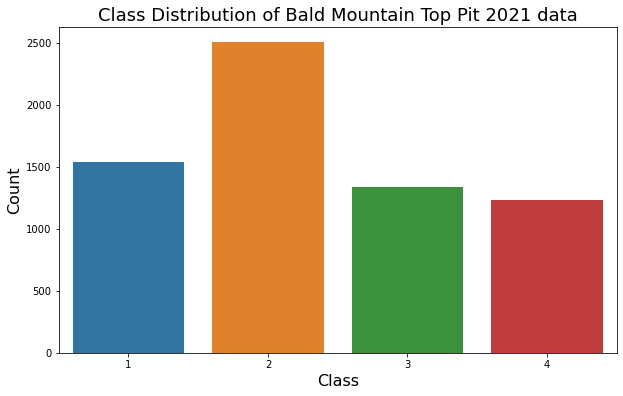

In [5]:
# tr, trl = data_load(os.path.join(main_dir, 'train_tensors_32.pt'),
#                                  os.path.join(main_dir, 'train_tile_labels_tensors_32.pt'))
# v, vl = data_load(os.path.join(main_dir, 'val_tensors_32.pt'),
#                                  os.path.join(main_dir, 'val_tile_labels_tensors_32.pt'))
# t, tl = data_load(os.path.join(main_dir, 'test_tensors_32.pt'),
#                                  os.path.join(main_dir, 'test_tile_labels_tensors_32.pt'))
# torch.save( torch.cat((tr, v, t), dim = 0), os.path.join(main_dir, 'all_tensors_32.pt') )
# torch.save( torch.cat((trl, vl, tl), dim = 0), os.path.join(main_dir, 'all_tile_labels_32.pt') )       

# stats_plot(os.path.join(main_dir, 'all_tensors_32.pt'), 
#            os.path.join(main_dir, 'all_tile_labels_32.pt'),
#           '')

stats_plot(os.path.join(main_dir, 'data_tensors_128_aug256-6.pt'), 
           os.path.join(main_dir, 'tile_labels_tensors_128_aug256-6.pt'),
          '')

## Data Splitting

In [6]:
def train_val_test_split(full_data, full_labels, stratify, save, val_test_ratio = 0.1):
    """
    Description:
        Split data into training, validation, and testing set.
        
    Args:
        full_data: The unsplit data (torch tensor or npy array)
        full_labels: The unsplit labels corresponding to the unsplit data (torch tensor or npy array)
        stratify: Maintain class proportion (bool)
        save: Save the data sets (bool)
        val_test_ratio: The ratio of validation/test set to the entire data set (float)

    Outputs:
        (X, y): tuple of the data and corresponding labels for training, validation, and testing set
    
    """
    
    # Convert torch tensor to numpy array
    if type(full_data) == torch.Tensor:
        full_data = full_data.numpy() 
    if type(full_labels) == torch.Tensor:
        full_labels = full_labels.numpy()
    if len(full_labels.shape) == 2:
        full_labels = full_labels.squeeze() # [N,]
        
    # Splitting the data
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(full_data, 
                                                           full_labels, 
                                                           test_size = val_test_ratio*2, 
                                                           random_state = 99, # seed = 99
                                                           stratify = full_labels) # stratify splitting

        X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                  y_test, 
                                  test_size = 0.5, 
                                  random_state = 99, # seed = 99
                                  stratify = y_test)
    else:
        X_train, X_test, y_train, y_test = train_test_split(full_data, 
                                                           full_labels, 
                                                           test_size = val_test_ratio*2, 
                                                           random_state = 99, # seed = 99
                                                           stratify = None)

        X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                  y_test, 
                                  test_size = 0.5, 
                                  random_state = 99, # seed = 99
                                  stratify = None)
    
    print('Train data: {:.1f}%'.format(X_train.shape[0] / full_data.shape[0] * 100))
    print('Val data: {:.1f}%'.format(X_val.shape[0] / full_data.shape[0] * 100))
    print('Test data: {:.1f}%'.format(X_test.shape[0] / full_data.shape[0] * 100))
    
    # Convert npy array back to torch tensor    
    X_train = torch.tensor(X_train)
    X_val = torch.tensor(X_val)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_val = torch.tensor(y_val)
    y_test = torch.tensor(y_test)
    
    # Save the data sets (optional)
    if save:
        torch.save(X_train, os.path.join(main_dir, 'train_tensors_{}.pt'.format(X_train.shape[2])))
        torch.save(X_val, os.path.join(main_dir, 'val_tensors_{}.pt'.format(X_train.shape[2])))
        torch.save(X_test, os.path.join(main_dir, 'test_tensors_{}.pt'.format(X_train.shape[2])))
        torch.save(y_train, os.path.join(main_dir, 'train_tile_labels_tensors_{}.pt'.format(X_train.shape[2])))
        torch.save(y_val, os.path.join(main_dir, 'val_tile_labels_tensors_{}.pt'.format(X_train.shape[2])))
        torch.save(y_test, os.path.join(main_dir, 'test_tile_labels_tensors_{}.pt'.format(X_train.shape[2])))

        print('Data sets saved')    
        
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [7]:
data_file = os.path.join(main_dir, 'data_tensors_128_aug256-6.pt')
label_file = os.path.join(main_dir, 'tile_labels_tensors_128_aug256-6.pt')
data, labels = data_load(df = data_file, lf = label_file)

Data shape: torch.Size([6600, 3, 128, 128])
Labels shape: torch.Size([6600, 1])


In [8]:
train, val, test = train_val_test_split(full_data = data,
                                        full_labels = labels,
                                        stratify = True,
                                       save = True)

Train data: 80.0%
Val data: 10.0%
Test data: 10.0%
Data sets saved


### Statistics of Train, Val, Test data sets

#### Training set

Total number of unique classes in data: 4
Class 1: 1,229 samples (23.3% of total)
Class 2: 2,003 samples (37.9% of total)
Class 3: 1,066 samples (20.2% of total)
Class 4: 982 samples (18.6% of total)
Total number of tiles: 5280




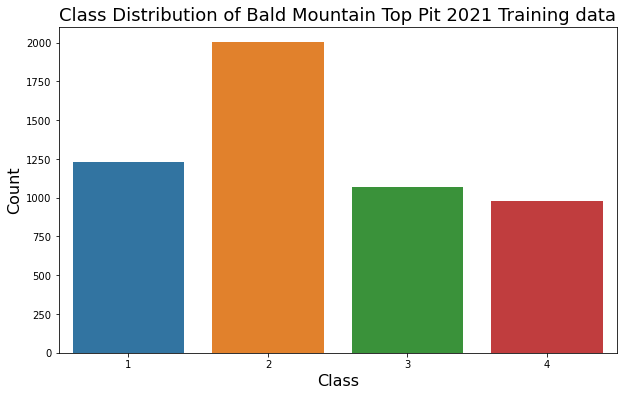

In [9]:
stats_plot(os.path.join(main_dir, 'train_tensors_128.pt'), 
           os.path.join(main_dir, 'train_tile_labels_tensors_128.pt'),
          'Training')

#### Validation set

Total number of unique classes in data: 4
Class 1: 154 samples (23.3% of total)
Class 2: 250 samples (37.9% of total)
Class 3: 133 samples (20.2% of total)
Class 4: 123 samples (18.6% of total)
Total number of tiles: 660




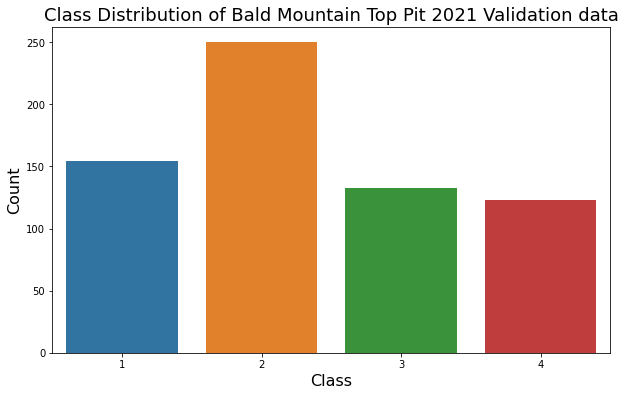

In [11]:
stats_plot(os.path.join(main_dir, 'val_tensors_128.pt'), 
           os.path.join(main_dir, 'val_tile_labels_tensors_128.pt'),
          'Validation')

#### Testing set

Total number of unique classes in data: 4
Class 1: 153 samples (23.2% of total)
Class 2: 250 samples (37.9% of total)
Class 3: 134 samples (20.3% of total)
Class 4: 123 samples (18.6% of total)
Total number of tiles: 660




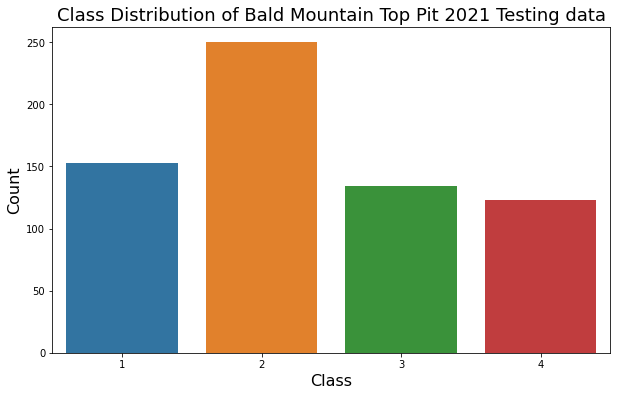

In [12]:
stats_plot(os.path.join(main_dir, 'test_tensors_128.pt'), 
           os.path.join(main_dir, 'test_tile_labels_tensors_128.pt'),
          'Testing')

## Model Architectures

### ResNet50 Transfer Learning 

Pytorch ResNet50 architecture (v1.5) performs downsampling in the 3x3 convolution layer instead of the 1x1 convolution layer as done in the original paper https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50

Also, torchvision v0.13 has recently been released with a new way of using pretrained weights. The current pretrained argument is deprecated and will be removed in later versions; however, it doesn't seem possible to install v0.13 right now. The deprecated method uses IMAGENET1K_V1 weights.

In [4]:
# ResNet50
from torchvision.models import resnet50

In [13]:
resnet50(pretrained = False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [67]:
# 3 layers
class ResNet_Classifier_1(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, num_class)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x       

# 4 layers
class ResNet_Classifier_2(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, layer3_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, layer3_size)
        self.fc4 = nn.Linear(layer3_size, num_class)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x    
    
# 5 layers
class ResNet_Classifier_3(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, layer3_size)
        self.fc4 = nn.Linear(layer3_size, layer4_size)
        self.fc5 = nn.Linear(layer4_size, num_class)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x       

# 3 layers with drop out in second layer
class ResNet_Classifier_4(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, num_class)
        self.dropout = nn.Dropout() # default p = 0.5
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(self.dropout(x))) # Drop out in second layer
        x = self.fc3(x)
        return x       

# 3 layers with drop out in first and second layer
class ResNet_Classifier_5(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, num_class)
        self.dropout = nn.Dropout() # default p = 0.5
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x))) # Drop out in first layer
        x = F.relu(self.fc2(self.dropout(x))) # Drop out in second layer
        x = self.fc3(x)
        return x   
    
# 3 layers with drop out and batch norm in first and second layer 
class ResNet_Classifier_6(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, num_class)
        self.dropout = nn.Dropout() # default p = 0.5
        self.bn1 = nn.BatchNorm1d(layer1_size)
        self.bn2 = nn.BatchNorm1d(layer2_size)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu( self.bn1(self.fc1(self.dropout(x))) ) # Drop out in first layer
        x = F.relu( self.bn2(self.fc2(self.dropout(x))) ) # Drop out in second layer
        x = self.fc3(x)
        return x   

# 5 layers with drop out in first and second last layer 
class ResNet_Classifier_7(nn.Module):
    def __init__(self, name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed):
        super().__init__()
        torch.manual_seed(seed)
        
        self.name = name
        self.fc1 = nn.Linear(2048, layer1_size)
        self.fc2 = nn.Linear(layer1_size, layer2_size)
        self.fc3 = nn.Linear(layer2_size, layer3_size)
        self.fc4 = nn.Linear(layer3_size, layer4_size)
        self.fc5 = nn.Linear(layer4_size, num_class)
        self.dropout = nn.Dropout() # default p = 0.5
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(self.dropout(x))) # drop out in first layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(self.dropout(x))) # drop out in second last layer
        x = self.fc5(x)
        return x      
    

In [66]:
summary(ResNet_Classifier_1('test', 2048, 2048, 2048, 1024, 4, 0), input_size = (1, 2048, 1, 1)) 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_Classifier_3                      --                        --
├─Linear: 1-1                            [1, 2048]                 4,196,352
├─Linear: 1-2                            [1, 2048]                 4,196,352
├─Linear: 1-3                            [1, 2048]                 4,196,352
├─Linear: 1-4                            [1, 1024]                 2,098,176
├─Linear: 1-5                            [1, 4]                    4,100
Total params: 14,691,332
Trainable params: 14,691,332
Non-trainable params: 0
Total mult-adds (M): 14.69
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 58.77
Estimated Total Size (MB): 58.83

#### 1. Feature Extraction

Keep pretrained weights frozen, remove FC and use custom classifier architecture

In [14]:
torch.nn.Sequential(*(list( resnet50(pretrained = False).children() )[:-1]))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [15]:
summary(torch.nn.Sequential(*(list( resnet50(pretrained = False).children() )[:-1])), 
        input_size = (1, 3, 64, 64)) 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 256, 16, 16]          --
│    └─Bottleneck: 2-1                   [1, 256, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           --
│ 

In [27]:
def transfer_model_feats(model, data, save, b_size = None, prefix = ''):
    """
    Description:
        Use a transfer learning model to get features before the FC layer.
        
    Args:
        model: A transfer learning model e.g. ResNet50
        data: The original data that has been preprocessed (Torch tensor)
        save: Save the features (bool)
        b_size: The batch size to use for computing large data sets (int)
        prefix: Prefix for file name (str)
    
    Outputs:
        features: Feature output from the transfer learning model (Torch tensor)
    
    """
    
    # To Enable GPU Usage
#     if use_cuda and torch.cuda.is_available():
#         data = data.cuda()
#         model.cuda()
#         print('CUDA is available! Using GPU ...')
#     else:
#         print('CUDA is unavailable. Using CPU ...')  
    
    # Set model to evaluation mode
    model.eval()

    i = 0 
    if b_size is not None:
        loader = torch.utils.data.DataLoader(data, 
                                     batch_size = b_size, # Smaller batch size
                                     shuffle = False) # Order matters
        features = []
        for img in loader:
            feature = model(img) # torch tensor [b_size, 3, H, W]
            features.append(feature)
            i += 1
            if i % 500 == 0:
                print('{} features extracted...'.format(i*b_size)) # Track progress
        features = torch.cat(features, dim = 0) # torch tensor [N, 3, H, W]
    else:            
        features = model(data)
        
    features = torch.from_numpy(features.cpu().detach().numpy()) # Remove any tracking updates
    
    if save:
        if prefix != '':
            prefix += '_'
        torch.save(features, os.path.join(main_dir, prefix + 'feat_tensors_{}.pt'.format(data.shape[2])))
        
    return features

#### 2. Finetuning

Update pretrained weights with new data. Trained classifier(s) from feature extraction method are used.

In [68]:
resnet50(pretrained = False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
summary(resnet50(pretrained = False))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [161]:
# Train selected layer
unfreeze = 'layer4' # Resnet layer to train

test = resnet50(pretrained = True)
for param in test.parameters():
    param.requires_grad = False # Freeze all layers
test.fc = ResNet_Classifier_1('test', 1024, 512, 4, 666) # Replace Resnet classifier with trained custom classifier

for name, param in test.named_parameters():
    if unfreeze in name:
        param.requires_grad = True # Unfreeze layers to be trained
        
for module in test.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.eval()   # Use running stats instead of batch stats for batch norm layers


In [167]:
# Train entire network
test2 = resnet50(pretrained = True)
test2.fc = ResNet_Classifier_1('test', 1024, 512, 4, 666)
summary(test2)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

***Note regarding setting models/layers to training/evaluation versus changing parameters' requires_grad:
Using model.train() and model.eval() just changes behaviour of certain layers during training versus evaluation. Changing parameter.requires_grad between True and False affects whether or not gradients will be computed for backpropagation in order to update the parameters. Setting requires_grad to True means the parameters will be updated while false will not update the parameters whatsoever. Setting model.train() while having requires_grad = False SHOULD NOT update those parameters.***

In [164]:
summary(test)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

### Training and Helper Functions

In [6]:
def check_point(name: 'str', dim, batch_size, seed, lr, epoch, num_epochs) -> str:
    """ 
    Description:
        Generate a file name for the model weights consisting of all the hyperparameter values

    Args:
        name: Model name (str)
        dim: Dimension of tile (int)
        batch_size: Size of each batch (int)
        seed: Seed used for weight initialization (int)
        lr: Learning rate (float)
        epoch: Current training epoch (int)    
        num_epochs: Total training epoch (int)
        
    outputs:
        file: A string with all of the hyperparameters concatenated
        
    """
    
    file = "{0}_Model_{1}_dim{2}_bs{3}_s{4}_lr{5}_epoch{6}_of_{7}".format(main_dir.split(' ')[-3] + '_' + main_dir.split(' ')[-1],
                                                                         name,
                                                                           dim,
                                                                           batch_size, 
                                                                           seed,
                                                                           lr,
                                                                           epoch, 
                                                                          num_epochs)
    
    return file

In [4]:
def save_loss_acc(path, **kwargs) -> list:
    """
    Description:
        Save losses and accuracies as strings in text file
        
    Args:
        path: The name of the model file corresponding to the losses and accuracies
        **kwargs: loss/accuracy with corresponding values
    
    Outputs:
        Keys of kwargs (list)
    
    """

    for key, args in kwargs.items():   
        with open(os.path.join(main_dir, path) + '_{}.txt'.format(key), 'a+') as f:
            for arg in args:
                f.write(str(arg) + '\n') # Convert to string
        print('{} saved'.format(key))
    
    return list(kwargs.keys())

def load_loss_acc(path, *args) -> dict:
    """
    Description:
        Load losses and accuracies from text files
        
    Args:
        path: The name of the model file corresponding to the losses and accuracies
        *args: loss/accuracy names
    
    Outputs:
        loaded_f: Dictionary containing the loss and accuracy
    
    """
    
    loaded_f = {}
    for arg in args:  
        values = []
        with open(os.path.join(main_dir, path) + '_{}.txt'.format(arg), 'r') as f:
            for row in f:
                values.append(float(row.strip())) # Convert string to float
            loaded_f[arg] = values
            print('{} loaded'.format(arg))
    
    return loaded_f

In [8]:
def curve_plot(path, **kwargs):
    """
    Description:
        Plot loss and accuracy.
        
    Args:
        path: The name of the model file corresponding to the losses and accuracies (str)
    
    Outputs
    
    """
    
    plt.figure(figsize = (10, 6))    
    if all('loss' in key for key in kwargs):
        plt.title("Training Curve (loss)", fontsize = 16)
        for key, args in kwargs.items():
            plt.plot(range(1, len(args)+1), args, label = key.split('_')[0].capitalize())
            plt.xlabel("Epochs", fontsize = 14)
            plt.ylabel("Loss", fontsize = 14)
#             plt.xticks(np.arange(1, len(args)+1 , 1.0))
        plt.legend(fontsize = 14)
        plt.savefig(os.path.join(main_dir, path) + '_Training Curve (Loss).png', facecolor = 'w') 
        plt.show()
        
    elif all('acc' in key for key in kwargs):
        plt.title("Training Curve (Accuracy)", fontsize = 16)
        for key, args in kwargs.items():
            plt.plot(range(1, len(args)+1), args, label = key.split('_')[0].capitalize())
            plt.xlabel("Epochs", fontsize = 14)
            plt.ylabel("Accuracy", fontsize = 14)
#             plt.xticks(np.arange(1, len(args)+1 , 1.0))
        plt.legend(fontsize = 14)
        plt.savefig(os.path.join(main_dir, path) + '_Training Curve (Accuracy).png', facecolor = 'w')  
        plt.show()
    else:
        print('Neither loss nor accuracy or both')
        
    return    

In [9]:
def training(model, dataloaders, criterion, optimizer, num_epochs, b_size, lr, seed, dim, name = '', bn2_freeze = False):
    """
    Description:
        Model training function
    
    Args:
        model: Model to be trained
        dataloaders: Dataloader containing the training and validation sets
        criterion: Loss function
        optimizer: Backpropagation method
        num_epochs: Current training epoch (int)  
        batch_size: Size of each batch (int)
        seed: Seed used for weight initialization (int)
        lr: Learning rate (float)
        dim: The tile dimension of the original data (int)
        name: Name for the model
        bn2_freeze: Freeze the batchnorm2d layers for finetuning (bool)
    
    Outputs:
        save_file: A string with all of the hyperparameters concatenated (str)
        keys: The names of the losses and accuracies (list)

    """
    
    # Get name from model class or use a user-specified one 
    if name != '':
        name = name
    else:
        name = model.name

    CUDA_LAUNCH_BLOCKING=1 
    train_losses, train_acc, val_losses, val_acc = [], [], [], []
    best_model_params = copy.deepcopy(model.state_dict()) # Initialize best model parameters as untrained
    best_val_acc = 0.0 # The epoch with the best validation accuracy
    start = time.time() # Track total run-time 
    
    ##########################################################################################
    # For each epoch:
    # 1. Train on training set, get training loss and accuracy
    # 2. Validate on validation set, get validation loss and accuracy
    # 3. Update highest validation accuracy and its corresponding model parameter if possible
    for epoch in range(num_epochs): # Starts from epoch 0
        tic = time.time() # Track run-time for each epoch
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        ###### Loop through training and validation sets ######
        for dataset_type in ['train', 'val']:
            if dataset_type == 'train':
                model.train()
                if bn2_freeze is True:
                    for module in model.modules():
                        if isinstance(module, nn.BatchNorm2d):
                            module.eval()   # Use running stats instead of batch stats for batch norm layers
            else:
                model.eval()
                
            ###### Loop through all batches ######
            iter_losses = 0.0 
            iter_corrects = 0
            for data, labels in dataloaders[dataset_type]:
                labels = labels.squeeze()
                if use_cuda and torch.cuda.is_available(): # GPU
                    data = data.cuda()
                    labels = labels.cuda()
                # Saves time for intermediate calculations (Does not override requires_grad)
                with torch.set_grad_enabled(dataset_type == 'train'): 
                    outputs = model(data)
                    loss = criterion(outputs, labels.long()) # Loss averaged over batch
                    if dataset_type == 'train':
                        loss.backward()
                        optimizer.step()
                    optimizer.zero_grad()                

                iter_losses += loss.item() * data.shape[0] # Get total loss per iter due to possibly different last batch size
                iter_corrects += torch.sum(torch.max(outputs, 1)[1] == labels.data)
            ###### Finish looping through all batches ######
            
            # Loss and accuracy for each epoch
            if dataset_type == 'train':
                train_losses.append(iter_losses / len(dataloaders[dataset_type].dataset))
                train_acc.append(iter_corrects.cpu().item() / len(dataloaders[dataset_type].dataset))
            else:
                val_losses.append(iter_losses / len(dataloaders[dataset_type].dataset))
                val_acc.append(iter_corrects.cpu().item() / len(dataloaders[dataset_type].dataset))
        ###### Finish looping through training and validation sets ######
                
        # Update the best validation accuracy and the corresponding model parameters
        if dataset_type == 'val' and best_val_acc < val_acc[epoch]:
            best_val_acc = val_acc[epoch]
            best_model_params = copy.deepcopy(model.state_dict()) 
            model_file = check_point(name = name, # Model file name of the best model
                                     dim = dim,
                                     batch_size = b_size, 
                                     seed = seed, 
                                     lr = lr, 
                                     epoch = epoch, # Current epoch
                                    num_epochs = num_epochs) 
                
        print('Train loss:{:.5f}, Train Acc:{:.4f}'.format(train_losses[epoch], train_acc[epoch]))
        print('Val loss:{:.5f}, Val Acc:{:.4f}'.format(val_losses[epoch], val_acc[epoch]))
        print('time elapsed (s): {:.2f}'.format(time.time() - tic)) 
        print('-' * 5)
        print('')
    ##########################################################################################
    
    # Save the best model weights, losses, and accuracies
    torch.save(best_model_params, os.path.join(main_dir, model_file) + '.pt')
    save_file = check_point(name = name, 
                                     dim = dim,
                                     batch_size = b_size, 
                                     seed = seed, 
                                     lr = lr, 
                                     epoch = num_epochs, # Signalling that it's the last epoch
                                    num_epochs = num_epochs) 
    keys = save_loss_acc(save_file, 
                         train_losses = train_losses,
                         train_acc = train_acc, 
                         val_losses = val_losses,
                         val_acc = val_acc) 
    
    print('')
    print('Training Complete')
    print('Best val acc: {:.4f}'.format(best_val_acc))
    print('Total Training Run-time: {:.2f} seconds'.format(time.time() - start))
    print('')
    
    return save_file, keys

## Data Preprocessing

In [9]:
def data_preproc(norm_file = None, file = None, file_labels = None):
    """
    Description:
        Preprocess the data and labels.
        
    Args:
        norm_file: The training data file name to be used for normalization (str)     
        file: The file of the data to be preprocessed (str or torch tensor)
        file_labels: The file of the labels (str or torch tensor)
    
    Outputs:
        data: Preprocessed data (torch tensor)
        labels: Preprocessed labels (torch tensor)
    
    """
    
    # Load the data
    if type(file) == str:
        data, labels = data_load(file, None, verbose = False) 
    else:
        data, labels =  file, None
        
    # Load the labels
    if type(file_labels) == str:
        _, labels = data_load(None, file_labels, verbose = False) 
    else:
        labels = file_labels        

    if norm_file is not None:
        train_data, _ = data_load(norm_file, verbose = False)

        # Ensure tensors are floats for normalization
        if train_data.dtype != torch.float:
            train_data = train_data.float()
        if data.dtype != torch.float:
            data = data.float()

        # Normalize the data by the training mean and std dev.(
        mean, std = train_data.mean([0, 2, 3]), train_data.std([0, 2, 3])
        print('Mean values of the three channels are: {}'.format(mean))
        print('Stdev values of the three channels are: {}'.format(std))
        print()

        transform_norm = transforms.Compose([transforms.Normalize(mean, std)])
        data = transform_norm(data) # (N, C, H, W)        
        print('Mean values of the three channels after input normalization are: {}'.format(data.mean([0,2,3])))
        print('Stdev values of the three channels after input normalization are: {}'.format(data.std([0,2,3])))         
        print()
    else:
        data = None
    
    # Subtract 1 from class labels such that they are in range [0, C) as required by nn.CrossEntropyLoss()
    if labels is not None: 
        if torch.min(labels).item() == 1:
            labels = labels - 1     
            print('Labels subtracted by 1')
        if len(labels.shape) == 2:
            labels = labels.squeeze() # Ensure tensor size is [N, ] for nn.CrossEntropyLoss()
            print('New labels shape: {}'.format(labels.shape))
    
    print('Data preprocessing complete \n')
    
    return data, labels

def loader(data, labels, b_size = None, shuffle = True):
    """
    Description:
        Load data and labels into dataloader.
        
    Args:
        data: Data to load (torch tensor)
        labels: Labels to load (torch tensor)
        b_size: Batch size to use for the dataloader (int)
    
    Outputs:
        loader: dataloader for the data and labels (torch dataloader)
    
    """
   
    if b_size is None:
        b_size = len(data)
    loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(data, labels), 
                                     batch_size = b_size, 
                                     shuffle = shuffle)

    return loader
    

## Method 1: Feature Extraction 

#### Extract the features

In [18]:
# For tensors that are too large to compute features
data, _ = data_preproc(norm_file = os.path.join(main_dir, 'train_tensors_32.pt'), 
                                              file = os.path.join(main_dir, 'val_tensors_32.pt'))

data_1, data_2 = torch.tensor_split(data, 2, dim = 0)
print(data_1.shape, data_2.shape)

data_1_ft = transfer_model_feats(model = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1])), 
                                 data = data_1, 
                                 save = False, b_size = 6, prefix = '')
data_2_ft = transfer_model_feats(model = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1])), 
                                 data = data_2, 
                                 save = False, b_size = 6, prefix = '')

print(data_1_ft.shape, data_2_ft.shape)
data_ft = torch.cat((data_1_ft, data_2_ft), dim = 0)
print(data_ft.shape)

torch.save(data_ft, os.path.join(main_dir, 'val_resnet50_feat_tensors_128.pt'))

Mean values of the three channels are: tensor([138.7794, 127.2458, 109.5673])
Stdev values of the three channels are: tensor([27.5850, 31.1816, 33.4441])

Mean values of the three channels after input normalization are: tensor([0.0077, 0.0141, 0.0224])
Stdev values of the three channels after input normalization are: tensor([0.9997, 1.0007, 0.9979])

Data preprocessing complete 

torch.Size([330, 3, 128, 128]) torch.Size([330, 3, 128, 128])
torch.Size([330, 2048, 1, 1]) torch.Size([330, 2048, 1, 1])
torch.Size([660, 2048, 1, 1])


In [ ]:
# Compute training features
train_data, _ = data_preproc(norm_file = os.path.join(main_dir, 'train_tensors_32.pt'), 
                                        file = os.path.join(main_dir, 'test_tensors_32.pt'))

train_fts = transfer_model_feats(model = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1])), 
                                 data = train_data, 
                                 save = True, b_size = 2, prefix = 'train_resnet50') 

Mean values of the three channels are: tensor([128.8190, 117.3616, 104.7915])
Stdev values of the three channels are: tensor([21.6749, 22.1651, 22.0286])

Mean values of the three channels after input normalization are: tensor([6.7272e-07, 5.2671e-07, 2.6420e-07])
Stdev values of the three channels after input normalization are: tensor([1.0000, 1.0000, 1.0000])

Data preprocessing complete 

1000 features extracted...
2000 features extracted...
3000 features extracted...


In [9]:
# Compute validation features
val_data, _ = data_preproc(norm_file = os.path.join(main_dir, 'train_tensors_96.pt'), 
                                       file = os.path.join(main_dir, 'val_tensors_96.pt'))

val_fts = transfer_model_feats(model = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1])),
                               data = val_data, 
                               save = True, b_size = 8, prefix = 'val_resnet50') # BN requires > 1

Mean values of the three channels are: tensor([128.6827, 117.1942, 104.6447])
Stdev values of the three channels are: tensor([21.6555, 22.0790, 21.9162])

Mean values of the three channels after input normalization are: tensor([0.0252, 0.0196, 0.0191])
Stdev values of the three channels after input normalization are: tensor([1.0141, 1.0174, 1.0199])

Data preprocessing complete 



In [19]:
# Compute test features
test_data, _ = data_preproc(norm_file = os.path.join(main_dir, 'train_tensors_128.pt'), 
                                       file = os.path.join(main_dir, 'test_tensors_128.pt'))

test_fts = transfer_model_feats(model = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1])),
                               data = test_data, 
                               save = True, b_size = 8, prefix = 'test_resnet50') # BN requires > 1

Mean values of the three channels are: tensor([128.8190, 117.3616, 104.7915])
Stdev values of the three channels are: tensor([21.6749, 22.1651, 22.0286])

Mean values of the three channels after input normalization are: tensor([-0.0003, -0.0062,  0.0004])
Stdev values of the three channels after input normalization are: tensor([1.0042, 1.0026, 0.9979])

Data preprocessing complete 



***Sanity check***

In [ ]:
# # Work with small sample first to test
# data, labels = data_preproc(os.path.join(main_dir, 'train_tensors_64.pt'), 
#             os.path.join(main_dir, 'train_tensors_64.pt'), 
#                             os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'))
# print(data.shape)
# print(labels.shape)

In [ ]:
# # Compute the features
# indices = torch.randperm(data.shape[0]) # Randomly create indices
# # Get 30 samples for training and validation subset
# subset_train_data = data[indices[:30]]
# subset_train_labels = labels[indices[:30]]
# subset_val_data = data[indices[-30:]]
# subset_val_labels = labels[indices[-30:]]

# model = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1]))
# train_fts = transfer_model_feats(model, subset_train_data, save = True, prefix = 'train-sanity-check_resnet50') 
# val_fts = transfer_model_feats(model, subset_val_data, save = True, prefix = 'val-sanity-check_resnet50')

# subset_loader = {'train': loader(train_fts, subset_train_labels), 'val': loader(val_fts, subset_val_labels)}

In [ ]:
# net = ResNet_Classifier_1('sanity-check', 1024, 512, 4, 0)
# if use_cuda and torch.cuda.is_available():
#     net.cuda()
#     print('CUDA is available! Training on GPU ...')
# else:
#     print('CUDA is unavailable. Training on CPU ...')   
    
# file_path, keys = training(model = net, 
#                             dataloaders = subset_loader, 
#                             criterion = nn.CrossEntropyLoss(), 
#                             optimizer = torch.optim.Adam(net.parameters(), lr = 0.001), 
#                             num_epochs = 10, 
#                             b_size = subset_train_data.shape[0], 
#                             lr = 0.001, 
#                             seed = 0,
#                           dim = 64)


In [ ]:
# print(file_path)
# print(keys)
# subset_loss = load_loss_acc(file_path, 'train_losses', 'val_losses')
# subset_acc = load_loss_acc(file_path, 'train_acc', 'val_acc')

In [ ]:
# curve_plot(file_path, **subset_loss)
# curve_plot(file_path, **subset_acc)

In [ ]:
# t = check_point('sanity-check', 64, 30, 0, 0.001, 6, 10)
# net.load_state_dict( torch.load(os.path.join(main_dir, t) + '.pt') )

***=========================================================================================================***

### Training (Default Classes)

In [15]:
# Load pre-computed feature data and preprocessed labels
train_fts = torch.load(os.path.join(main_dir, 'train_resnet50_feat_tensors_128.pt'))
_, train_labels = data_preproc(file_labels = os.path.join(main_dir, 'train_tile_labels_tensors_128.pt'))

val_fts = torch.load(os.path.join(main_dir, 'val_resnet50_feat_tensors_128.pt'))
_, val_labels = data_preproc(file_labels = os.path.join(main_dir, 'val_tile_labels_tensors_128.pt'))
print(train_fts.shape, train_labels.shape, val_fts.shape, val_labels.shape)

Data preprocessing complete 

Data preprocessing complete 

torch.Size([4888, 2048, 1, 1]) torch.Size([4888]) torch.Size([611, 2048, 1, 1]) torch.Size([611])


CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.61707, Train Acc:0.1854
Val loss:1.61384, Val Acc:0.3044
time elapsed (s): 0.33
-----

Epoch 2/170
Train loss:1.64988, Train Acc:0.3056
Val loss:1.50691, Val Acc:0.2651
time elapsed (s): 0.16
-----

Epoch 3/170
Train loss:1.50026, Train Acc:0.2743
Val loss:1.50541, Val Acc:0.3912
time elapsed (s): 0.07
-----

Epoch 4/170
Train loss:1.48529, Train Acc:0.4151
Val loss:1.47705, Val Acc:0.4059
time elapsed (s): 0.07
-----

Epoch 5/170
Train loss:1.46079, Train Acc:0.4304
Val loss:1.41814, Val Acc:0.4517
time elapsed (s): 0.08
-----

Epoch 6/170
Train loss:1.40469, Train Acc:0.4589
Val loss:1.33740, Val Acc:0.4599
time elapsed (s): 0.15
-----

Epoch 7/170
Train loss:1.32815, Train Acc:0.4703
Val loss:1.26119, Val Acc:0.4583
time elapsed (s): 0.06
-----

Epoch 8/170
Train loss:1.26308, Train Acc:0.4683
Val loss:1.21184, Val Acc:0.4632
time elapsed (s): 0.07
-----

Epoch 9/170
Train loss:1.22400, Train Acc:0.4859
Val loss:1.17457

Train loss:0.66069, Train Acc:0.7408
Val loss:0.76065, Val Acc:0.6989
time elapsed (s): 0.11
-----

Epoch 77/170
Train loss:0.64484, Train Acc:0.7482
Val loss:0.75399, Val Acc:0.7054
time elapsed (s): 0.17
-----

Epoch 78/170
Train loss:0.64210, Train Acc:0.7496
Val loss:0.74257, Val Acc:0.6989
time elapsed (s): 0.09
-----

Epoch 79/170
Train loss:0.63691, Train Acc:0.7512
Val loss:0.75121, Val Acc:0.7038
time elapsed (s): 0.10
-----

Epoch 80/170
Train loss:0.64292, Train Acc:0.7445
Val loss:0.74686, Val Acc:0.7054
time elapsed (s): 0.09
-----

Epoch 81/170
Train loss:0.61927, Train Acc:0.7590
Val loss:0.74390, Val Acc:0.7119
time elapsed (s): 0.18
-----

Epoch 82/170
Train loss:0.63246, Train Acc:0.7482
Val loss:0.74393, Val Acc:0.7054
time elapsed (s): 0.10
-----

Epoch 83/170
Train loss:0.62488, Train Acc:0.7514
Val loss:0.74107, Val Acc:0.6989
time elapsed (s): 0.09
-----

Epoch 84/170
Train loss:0.61173, Train Acc:0.7574
Val loss:0.73541, Val Acc:0.7136
time elapsed (s): 0.10
---

Train loss:0.39779, Train Acc:0.8521
Val loss:0.66974, Val Acc:0.7676
time elapsed (s): 0.08
-----

Epoch 151/170
Train loss:0.37806, Train Acc:0.8599
Val loss:0.68136, Val Acc:0.7512
time elapsed (s): 0.14
-----

Epoch 152/170
Train loss:0.37024, Train Acc:0.8611
Val loss:0.67513, Val Acc:0.7643
time elapsed (s): 0.09
-----

Epoch 153/170
Train loss:0.36985, Train Acc:0.8629
Val loss:0.68337, Val Acc:0.7578
time elapsed (s): 0.07
-----

Epoch 154/170
Train loss:0.36823, Train Acc:0.8595
Val loss:0.68974, Val Acc:0.7512
time elapsed (s): 0.07
-----

Epoch 155/170
Train loss:0.36761, Train Acc:0.8574
Val loss:0.67514, Val Acc:0.7627
time elapsed (s): 0.08
-----

Epoch 156/170
Train loss:0.37037, Train Acc:0.8582
Val loss:0.67547, Val Acc:0.7660
time elapsed (s): 0.15
-----

Epoch 157/170
Train loss:0.36089, Train Acc:0.8654
Val loss:0.68334, Val Acc:0.7594
time elapsed (s): 0.07
-----

Epoch 158/170
Train loss:0.35217, Train Acc:0.8682
Val loss:0.68198, Val Acc:0.7594
time elapsed (s): 

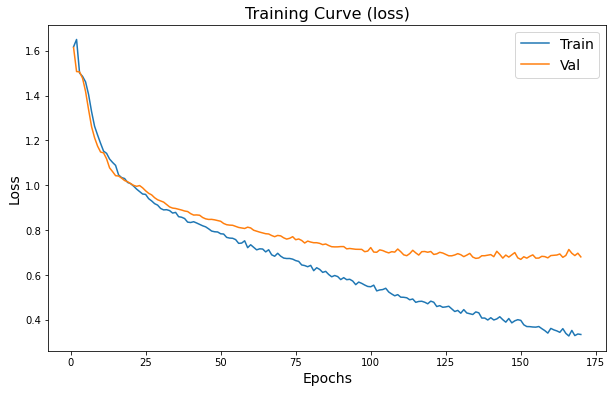

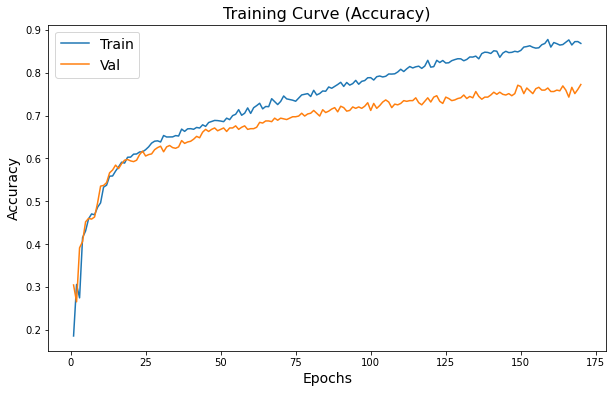

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.63400, Train Acc:0.1326
Val loss:1.59286, Val Acc:0.3044
time elapsed (s): 0.10
-----

Epoch 2/170
Train loss:1.62163, Train Acc:0.3056
Val loss:1.50555, Val Acc:0.2700
time elapsed (s): 0.10
-----

Epoch 3/170
Train loss:1.50312, Train Acc:0.2870
Val loss:1.49373, Val Acc:0.4452
time elapsed (s): 0.20
-----

Epoch 4/170
Train loss:1.47833, Train Acc:0.4159
Val loss:1.46257, Val Acc:0.4386
time elapsed (s): 0.10
-----

Epoch 5/170
Train loss:1.44633, Train Acc:0.4227
Val loss:1.39865, Val Acc:0.4321
time elapsed (s): 0.10
-----

Epoch 6/170
Train loss:1.38370, Train Acc:0.4339
Val loss:1.32076, Val Acc:0.4468
time elapsed (s): 0.11
-----

Epoch 7/170
Train loss:1.31061, Train Acc:0.4615
Val loss:1.25558, Val Acc:0.4550
time elapsed (s): 0.17
-----

Epoch 8/170
Train loss:1.25981, Train Acc:0.4619
Val loss:1.20227, Val Acc:0.4452
time elapsed (s): 0.11
-----

Epoch 9/170
Train loss:1.21859, Train Acc:0.4728
Val loss:1.15676

Train loss:0.65437, Train Acc:0.7439
Val loss:0.76186, Val Acc:0.7005
time elapsed (s): 0.08
-----

Epoch 75/170
Train loss:0.65723, Train Acc:0.7414
Val loss:0.76405, Val Acc:0.7021
time elapsed (s): 0.09
-----

Epoch 76/170
Train loss:0.64100, Train Acc:0.7465
Val loss:0.75569, Val Acc:0.7021
time elapsed (s): 0.06
-----

Epoch 77/170
Train loss:0.64564, Train Acc:0.7469
Val loss:0.75198, Val Acc:0.7070
time elapsed (s): 0.15
-----

Epoch 78/170
Train loss:0.64156, Train Acc:0.7461
Val loss:0.75030, Val Acc:0.7103
time elapsed (s): 0.07
-----

Epoch 79/170
Train loss:0.63322, Train Acc:0.7490
Val loss:0.74930, Val Acc:0.7169
time elapsed (s): 0.06
-----

Epoch 80/170
Train loss:0.63265, Train Acc:0.7457
Val loss:0.74555, Val Acc:0.7070
time elapsed (s): 0.06
-----

Epoch 81/170
Train loss:0.62212, Train Acc:0.7533
Val loss:0.74696, Val Acc:0.7103
time elapsed (s): 0.08
-----

Epoch 82/170
Train loss:0.61277, Train Acc:0.7584
Val loss:0.74156, Val Acc:0.7054
time elapsed (s): 0.14
---

Train loss:0.38100, Train Acc:0.8537
Val loss:0.68676, Val Acc:0.7480
time elapsed (s): 0.19
-----

Epoch 149/170
Train loss:0.36885, Train Acc:0.8590
Val loss:0.69392, Val Acc:0.7430
time elapsed (s): 0.10
-----

Epoch 150/170
Train loss:0.37694, Train Acc:0.8539
Val loss:0.68523, Val Acc:0.7496
time elapsed (s): 0.09
-----

Epoch 151/170
Train loss:0.36198, Train Acc:0.8599
Val loss:0.70506, Val Acc:0.7529
time elapsed (s): 0.10
-----

Epoch 152/170
Train loss:0.37621, Train Acc:0.8558
Val loss:0.69523, Val Acc:0.7463
time elapsed (s): 0.17
-----

Epoch 153/170
Train loss:0.38538, Train Acc:0.8519
Val loss:0.69265, Val Acc:0.7447
time elapsed (s): 0.11
-----

Epoch 154/170
Train loss:0.36145, Train Acc:0.8664
Val loss:0.71962, Val Acc:0.7398
time elapsed (s): 0.09
-----

Epoch 155/170
Train loss:0.38072, Train Acc:0.8547
Val loss:0.66836, Val Acc:0.7529
time elapsed (s): 0.10
-----

Epoch 156/170
Train loss:0.35136, Train Acc:0.8701
Val loss:0.66752, Val Acc:0.7529
time elapsed (s): 

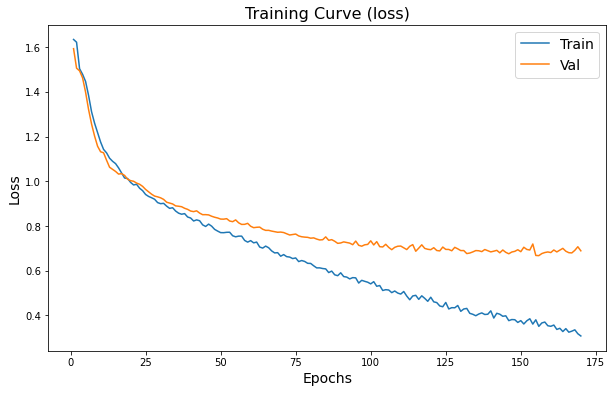

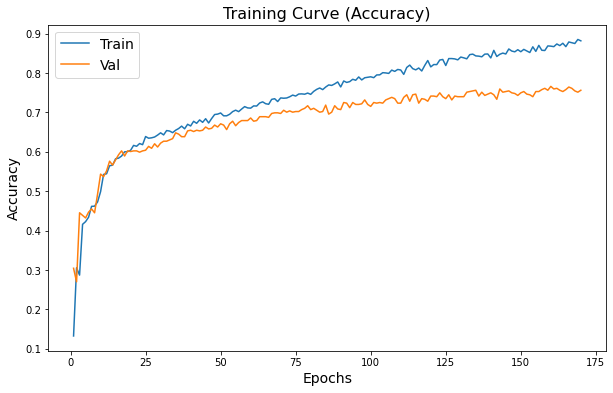

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.62612, Train Acc:0.1641
Val loss:1.60878, Val Acc:0.3044
time elapsed (s): 0.09
-----

Epoch 2/170
Train loss:1.64673, Train Acc:0.3059
Val loss:1.50238, Val Acc:0.2995
time elapsed (s): 0.10
-----

Epoch 3/170
Train loss:1.49522, Train Acc:0.3159
Val loss:1.51045, Val Acc:0.4403
time elapsed (s): 0.18
-----

Epoch 4/170
Train loss:1.48990, Train Acc:0.4149
Val loss:1.47748, Val Acc:0.4403
time elapsed (s): 0.09
-----

Epoch 5/170
Train loss:1.45943, Train Acc:0.4669
Val loss:1.41276, Val Acc:0.4534
time elapsed (s): 0.11
-----

Epoch 6/170
Train loss:1.39904, Train Acc:0.4527
Val loss:1.33093, Val Acc:0.4190
time elapsed (s): 0.09
-----

Epoch 7/170
Train loss:1.32269, Train Acc:0.4503
Val loss:1.26435, Val Acc:0.4288
time elapsed (s): 0.18
-----

Epoch 8/170
Train loss:1.26967, Train Acc:0.4460
Val loss:1.21107, Val Acc:0.4583
time elapsed (s): 0.11
-----

Epoch 9/170
Train loss:1.22838, Train Acc:0.4642
Val loss:1.15415

Train loss:0.65310, Train Acc:0.7418
Val loss:0.75274, Val Acc:0.7185
time elapsed (s): 0.11
-----

Epoch 77/170
Train loss:0.64336, Train Acc:0.7492
Val loss:0.75146, Val Acc:0.7136
time elapsed (s): 0.17
-----

Epoch 78/170
Train loss:0.64465, Train Acc:0.7439
Val loss:0.75024, Val Acc:0.6874
time elapsed (s): 0.11
-----

Epoch 79/170
Train loss:0.62807, Train Acc:0.7510
Val loss:0.75252, Val Acc:0.7038
time elapsed (s): 0.10
-----

Epoch 80/170
Train loss:0.64208, Train Acc:0.7449
Val loss:0.74287, Val Acc:0.7054
time elapsed (s): 0.10
-----

Epoch 81/170
Train loss:0.63705, Train Acc:0.7547
Val loss:0.74081, Val Acc:0.6956
time elapsed (s): 0.09
-----

Epoch 82/170
Train loss:0.62601, Train Acc:0.7557
Val loss:0.74780, Val Acc:0.6989
time elapsed (s): 0.17
-----

Epoch 83/170
Train loss:0.62894, Train Acc:0.7469
Val loss:0.73521, Val Acc:0.6939
time elapsed (s): 0.11
-----

Epoch 84/170
Train loss:0.61837, Train Acc:0.7594
Val loss:0.74129, Val Acc:0.6923
time elapsed (s): 0.10
---

Train loss:0.38684, Train Acc:0.8507
Val loss:0.68258, Val Acc:0.7545
time elapsed (s): 0.07
-----

Epoch 150/170
Train loss:0.38552, Train Acc:0.8525
Val loss:0.69923, Val Acc:0.7529
time elapsed (s): 0.07
-----

Epoch 151/170
Train loss:0.36621, Train Acc:0.8631
Val loss:0.70073, Val Acc:0.7627
time elapsed (s): 0.06
-----

Epoch 152/170
Train loss:0.36652, Train Acc:0.8642
Val loss:0.69765, Val Acc:0.7545
time elapsed (s): 0.16
-----

Epoch 153/170
Train loss:0.35494, Train Acc:0.8652
Val loss:0.69267, Val Acc:0.7529
time elapsed (s): 0.06
-----

Epoch 154/170
Train loss:0.36948, Train Acc:0.8609
Val loss:0.68649, Val Acc:0.7561
time elapsed (s): 0.06
-----

Epoch 155/170
Train loss:0.36488, Train Acc:0.8629
Val loss:0.68710, Val Acc:0.7512
time elapsed (s): 0.07
-----

Epoch 156/170
Train loss:0.34329, Train Acc:0.8703
Val loss:0.69344, Val Acc:0.7480
time elapsed (s): 0.08
-----

Epoch 157/170
Train loss:0.35282, Train Acc:0.8662
Val loss:0.68427, Val Acc:0.7610
time elapsed (s): 

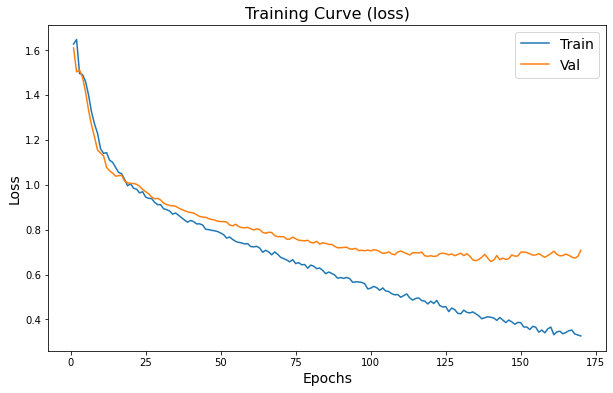

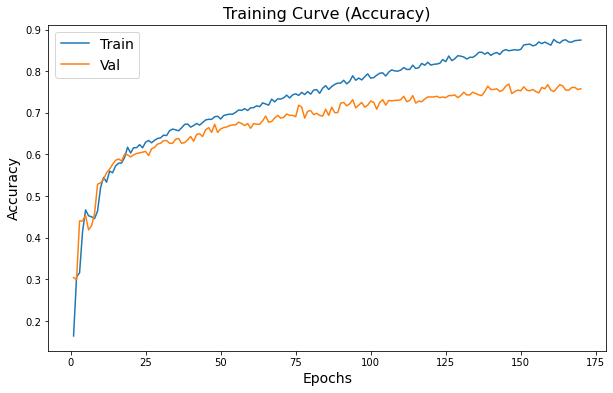

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.60269, Train Acc:0.2275
Val loss:1.64455, Val Acc:0.3044
time elapsed (s): 0.10
-----

Epoch 2/170
Train loss:1.69143, Train Acc:0.3077
Val loss:1.50470, Val Acc:0.2651
time elapsed (s): 0.09
-----

Epoch 3/170
Train loss:1.49943, Train Acc:0.2717
Val loss:1.50550, Val Acc:0.4550
time elapsed (s): 0.19
-----

Epoch 4/170
Train loss:1.48171, Train Acc:0.4507
Val loss:1.48229, Val Acc:0.4468
time elapsed (s): 0.11
-----

Epoch 5/170
Train loss:1.45893, Train Acc:0.4378
Val loss:1.42181, Val Acc:0.4877
time elapsed (s): 0.10
-----

Epoch 6/170
Train loss:1.40243, Train Acc:0.4564
Val loss:1.33529, Val Acc:0.4779
time elapsed (s): 0.10
-----

Epoch 7/170
Train loss:1.32341, Train Acc:0.4734
Val loss:1.25010, Val Acc:0.4730
time elapsed (s): 0.10
-----

Epoch 8/170
Train loss:1.24251, Train Acc:0.4885
Val loss:1.19433, Val Acc:0.4697
time elapsed (s): 0.17
-----

Epoch 9/170
Train loss:1.20724, Train Acc:0.4849
Val loss:1.16944

Train loss:0.65707, Train Acc:0.7416
Val loss:0.75587, Val Acc:0.6972
time elapsed (s): 0.14
-----

Epoch 75/170
Train loss:0.64724, Train Acc:0.7529
Val loss:0.74646, Val Acc:0.6972
time elapsed (s): 0.07
-----

Epoch 76/170
Train loss:0.64564, Train Acc:0.7473
Val loss:0.73630, Val Acc:0.7087
time elapsed (s): 0.06
-----

Epoch 77/170
Train loss:0.64277, Train Acc:0.7449
Val loss:0.74166, Val Acc:0.7021
time elapsed (s): 0.07
-----

Epoch 78/170
Train loss:0.63004, Train Acc:0.7541
Val loss:0.73729, Val Acc:0.7070
time elapsed (s): 0.15
-----

Epoch 79/170
Train loss:0.62839, Train Acc:0.7494
Val loss:0.74029, Val Acc:0.7103
time elapsed (s): 0.07
-----

Epoch 80/170
Train loss:0.63809, Train Acc:0.7486
Val loss:0.72718, Val Acc:0.7070
time elapsed (s): 0.09
-----

Epoch 81/170
Train loss:0.63011, Train Acc:0.7572
Val loss:0.73062, Val Acc:0.7119
time elapsed (s): 0.08
-----

Epoch 82/170
Train loss:0.61450, Train Acc:0.7551
Val loss:0.74659, Val Acc:0.7087
time elapsed (s): 0.17
---

Train loss:0.40719, Train Acc:0.8425
Val loss:0.67307, Val Acc:0.7512
time elapsed (s): 0.07
-----

Epoch 148/170
Train loss:0.37957, Train Acc:0.8576
Val loss:0.67187, Val Acc:0.7430
time elapsed (s): 0.07
-----

Epoch 149/170
Train loss:0.38790, Train Acc:0.8470
Val loss:0.67159, Val Acc:0.7627
time elapsed (s): 0.15
-----

Epoch 150/170
Train loss:0.37293, Train Acc:0.8580
Val loss:0.67838, Val Acc:0.7545
time elapsed (s): 0.06
-----

Epoch 151/170
Train loss:0.37050, Train Acc:0.8570
Val loss:0.66649, Val Acc:0.7545
time elapsed (s): 0.08
-----

Epoch 152/170
Train loss:0.38010, Train Acc:0.8605
Val loss:0.68259, Val Acc:0.7627
time elapsed (s): 0.08
-----

Epoch 153/170
Train loss:0.38410, Train Acc:0.8531
Val loss:0.67033, Val Acc:0.7774
time elapsed (s): 0.14
-----

Epoch 154/170
Train loss:0.38444, Train Acc:0.8505
Val loss:0.65820, Val Acc:0.7676
time elapsed (s): 0.10
-----

Epoch 155/170
Train loss:0.37581, Train Acc:0.8560
Val loss:0.65186, Val Acc:0.7692
time elapsed (s): 

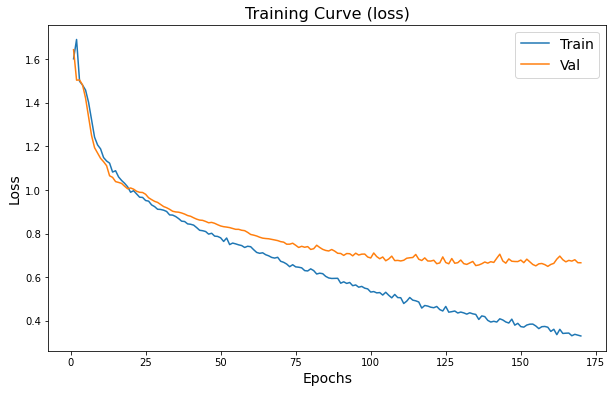

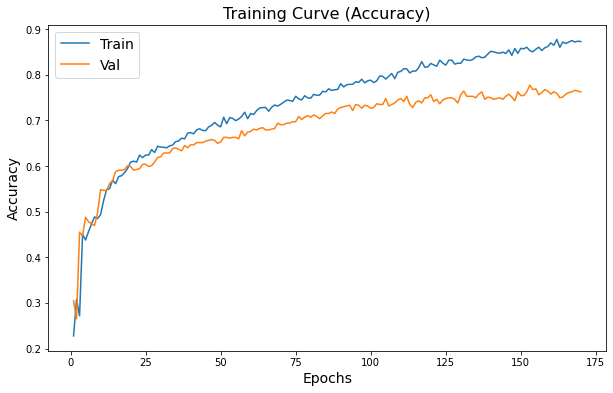

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.60504, Train Acc:0.2437
Val loss:1.64684, Val Acc:0.3486
time elapsed (s): 0.09
-----

Epoch 2/170
Train loss:1.68817, Train Acc:0.3398
Val loss:1.48042, Val Acc:0.3715
time elapsed (s): 0.10
-----

Epoch 3/170
Train loss:1.47220, Train Acc:0.3875
Val loss:1.48277, Val Acc:0.4583
time elapsed (s): 0.10
-----

Epoch 4/170
Train loss:1.46884, Train Acc:0.4325
Val loss:1.44105, Val Acc:0.4697
time elapsed (s): 0.17
-----

Epoch 5/170
Train loss:1.42447, Train Acc:0.4587
Val loss:1.37328, Val Acc:0.4632
time elapsed (s): 0.10
-----

Epoch 6/170
Train loss:1.35921, Train Acc:0.4736
Val loss:1.29804, Val Acc:0.4664
time elapsed (s): 0.10
-----

Epoch 7/170
Train loss:1.28400, Train Acc:0.4755
Val loss:1.24110, Val Acc:0.4599
time elapsed (s): 0.09
-----

Epoch 8/170
Train loss:1.23155, Train Acc:0.4808
Val loss:1.19434, Val Acc:0.4861
time elapsed (s): 0.11
-----

Epoch 9/170
Train loss:1.19452, Train Acc:0.4904
Val loss:1.16492

Train loss:0.63955, Train Acc:0.7477
Val loss:0.74872, Val Acc:0.7087
time elapsed (s): 0.16
-----

Epoch 76/170
Train loss:0.63188, Train Acc:0.7580
Val loss:0.75004, Val Acc:0.7021
time elapsed (s): 0.08
-----

Epoch 77/170
Train loss:0.62308, Train Acc:0.7563
Val loss:0.74959, Val Acc:0.7152
time elapsed (s): 0.07
-----

Epoch 78/170
Train loss:0.62636, Train Acc:0.7598
Val loss:0.73835, Val Acc:0.7070
time elapsed (s): 0.08
-----

Epoch 79/170
Train loss:0.62359, Train Acc:0.7613
Val loss:0.74079, Val Acc:0.7021
time elapsed (s): 0.16
-----

Epoch 80/170
Train loss:0.61685, Train Acc:0.7627
Val loss:0.74020, Val Acc:0.6956
time elapsed (s): 0.08
-----

Epoch 81/170
Train loss:0.60165, Train Acc:0.7678
Val loss:0.72742, Val Acc:0.7103
time elapsed (s): 0.08
-----

Epoch 82/170
Train loss:0.62095, Train Acc:0.7543
Val loss:0.73091, Val Acc:0.7250
time elapsed (s): 0.08
-----

Epoch 83/170
Train loss:0.60322, Train Acc:0.7668
Val loss:0.72786, Val Acc:0.7201
time elapsed (s): 0.10
---

Train loss:0.36498, Train Acc:0.8552
Val loss:0.66518, Val Acc:0.7627
time elapsed (s): 0.10
-----

Epoch 150/170
Train loss:0.35392, Train Acc:0.8707
Val loss:0.66542, Val Acc:0.7627
time elapsed (s): 0.18
-----

Epoch 151/170
Train loss:0.35751, Train Acc:0.8617
Val loss:0.66720, Val Acc:0.7594
time elapsed (s): 0.10
-----

Epoch 152/170
Train loss:0.35300, Train Acc:0.8691
Val loss:0.66054, Val Acc:0.7578
time elapsed (s): 0.09
-----

Epoch 153/170
Train loss:0.34967, Train Acc:0.8644
Val loss:0.65050, Val Acc:0.7594
time elapsed (s): 0.10
-----

Epoch 154/170
Train loss:0.33535, Train Acc:0.8793
Val loss:0.65964, Val Acc:0.7578
time elapsed (s): 0.18
-----

Epoch 155/170
Train loss:0.34881, Train Acc:0.8725
Val loss:0.67787, Val Acc:0.7610
time elapsed (s): 0.09
-----

Epoch 156/170
Train loss:0.34301, Train Acc:0.8697
Val loss:0.66749, Val Acc:0.7545
time elapsed (s): 0.09
-----

Epoch 157/170
Train loss:0.35031, Train Acc:0.8685
Val loss:0.66560, Val Acc:0.7627
time elapsed (s): 

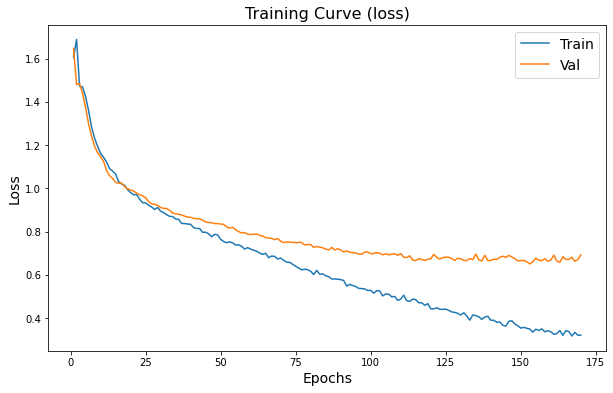

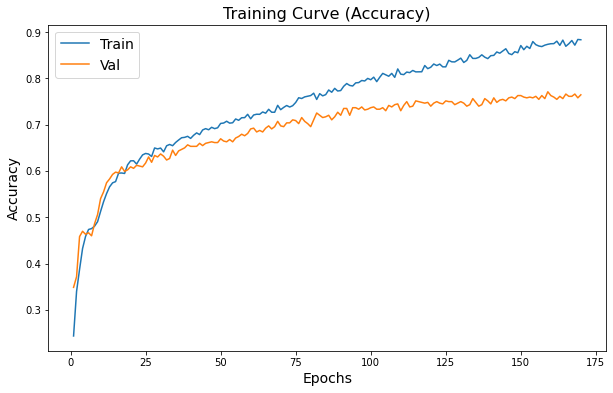

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.62297, Train Acc:0.1635
Val loss:1.60424, Val Acc:0.3044
time elapsed (s): 0.16
-----

Epoch 2/170
Train loss:1.63735, Train Acc:0.3073
Val loss:1.48787, Val Acc:0.3011
time elapsed (s): 0.11
-----

Epoch 3/170
Train loss:1.48607, Train Acc:0.3179
Val loss:1.48659, Val Acc:0.4730
time elapsed (s): 0.09
-----

Epoch 4/170
Train loss:1.46787, Train Acc:0.4525
Val loss:1.44515, Val Acc:0.4697
time elapsed (s): 0.10
-----

Epoch 5/170
Train loss:1.42866, Train Acc:0.4550
Val loss:1.36886, Val Acc:0.4926
time elapsed (s): 0.18
-----

Epoch 6/170
Train loss:1.35538, Train Acc:0.4650
Val loss:1.27784, Val Acc:0.4779
time elapsed (s): 0.09
-----

Epoch 7/170
Train loss:1.27590, Train Acc:0.4806
Val loss:1.20984, Val Acc:0.4746
time elapsed (s): 0.09
-----

Epoch 8/170
Train loss:1.21751, Train Acc:0.4830
Val loss:1.17222, Val Acc:0.4910
time elapsed (s): 0.11
-----

Epoch 9/170
Train loss:1.19052, Train Acc:0.4906
Val loss:1.14937

Train loss:0.64702, Train Acc:0.7437
Val loss:0.75383, Val Acc:0.7087
time elapsed (s): 0.18
-----

Epoch 76/170
Train loss:0.65114, Train Acc:0.7422
Val loss:0.73631, Val Acc:0.7103
time elapsed (s): 0.09
-----

Epoch 77/170
Train loss:0.64617, Train Acc:0.7518
Val loss:0.73452, Val Acc:0.7070
time elapsed (s): 0.09
-----

Epoch 78/170
Train loss:0.63011, Train Acc:0.7606
Val loss:0.73424, Val Acc:0.7005
time elapsed (s): 0.10
-----

Epoch 79/170
Train loss:0.62299, Train Acc:0.7584
Val loss:0.73055, Val Acc:0.7070
time elapsed (s): 0.17
-----

Epoch 80/170
Train loss:0.62084, Train Acc:0.7551
Val loss:0.73691, Val Acc:0.7103
time elapsed (s): 0.10
-----

Epoch 81/170
Train loss:0.63581, Train Acc:0.7504
Val loss:0.73472, Val Acc:0.7070
time elapsed (s): 0.09
-----

Epoch 82/170
Train loss:0.61141, Train Acc:0.7574
Val loss:0.73497, Val Acc:0.7087
time elapsed (s): 0.09
-----

Epoch 83/170
Train loss:0.61214, Train Acc:0.7625
Val loss:0.72657, Val Acc:0.7070
time elapsed (s): 0.10
---

Train loss:0.38674, Train Acc:0.8537
Val loss:0.66916, Val Acc:0.7627
time elapsed (s): 0.11
-----

Epoch 149/170
Train loss:0.36691, Train Acc:0.8613
Val loss:0.68353, Val Acc:0.7430
time elapsed (s): 0.16
-----

Epoch 150/170
Train loss:0.37353, Train Acc:0.8621
Val loss:0.66218, Val Acc:0.7496
time elapsed (s): 0.11
-----

Epoch 151/170
Train loss:0.37237, Train Acc:0.8556
Val loss:0.66021, Val Acc:0.7627
time elapsed (s): 0.08
-----

Epoch 152/170
Train loss:0.38979, Train Acc:0.8482
Val loss:0.68620, Val Acc:0.7430
time elapsed (s): 0.08
-----

Epoch 153/170
Train loss:0.36695, Train Acc:0.8621
Val loss:0.68280, Val Acc:0.7610
time elapsed (s): 0.16
-----

Epoch 154/170
Train loss:0.34751, Train Acc:0.8652
Val loss:0.67921, Val Acc:0.7529
time elapsed (s): 0.08
-----

Epoch 155/170
Train loss:0.36313, Train Acc:0.8623
Val loss:0.66696, Val Acc:0.7660
time elapsed (s): 0.08
-----

Epoch 156/170
Train loss:0.34049, Train Acc:0.8734
Val loss:0.68789, Val Acc:0.7529
time elapsed (s): 

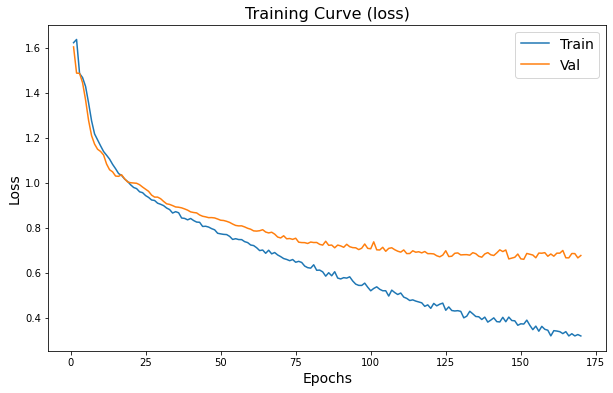

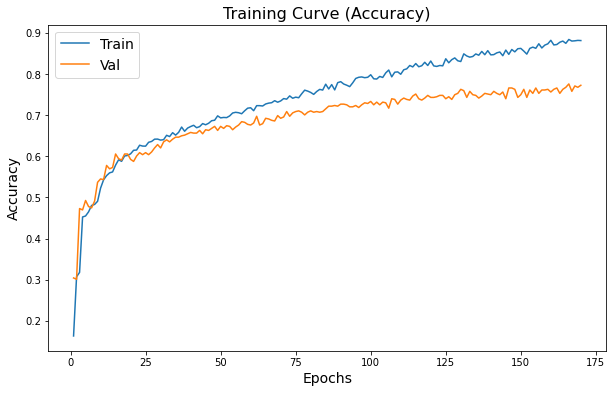

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.59701, Train Acc:0.2651
Val loss:1.66613, Val Acc:0.3044
time elapsed (s): 0.09
-----

Epoch 2/170
Train loss:1.71892, Train Acc:0.3099
Val loss:1.48476, Val Acc:0.3568
time elapsed (s): 0.10
-----

Epoch 3/170
Train loss:1.48205, Train Acc:0.3550
Val loss:1.49594, Val Acc:0.4288
time elapsed (s): 0.10
-----

Epoch 4/170
Train loss:1.47759, Train Acc:0.4464
Val loss:1.46614, Val Acc:0.4517
time elapsed (s): 0.17
-----

Epoch 5/170
Train loss:1.44715, Train Acc:0.4601
Val loss:1.40411, Val Acc:0.4583
time elapsed (s): 0.12
-----

Epoch 6/170
Train loss:1.38782, Train Acc:0.4779
Val loss:1.32347, Val Acc:0.4697
time elapsed (s): 0.09
-----

Epoch 7/170
Train loss:1.30959, Train Acc:0.4767
Val loss:1.24813, Val Acc:0.4566
time elapsed (s): 0.10
-----

Epoch 8/170
Train loss:1.25016, Train Acc:0.4761
Val loss:1.19551, Val Acc:0.4730
time elapsed (s): 0.12
-----

Epoch 9/170
Train loss:1.20062, Train Acc:0.4808
Val loss:1.15430

Train loss:0.65558, Train Acc:0.7471
Val loss:0.75361, Val Acc:0.7169
time elapsed (s): 0.11
-----

Epoch 75/170
Train loss:0.64423, Train Acc:0.7498
Val loss:0.75585, Val Acc:0.6989
time elapsed (s): 0.17
-----

Epoch 76/170
Train loss:0.64867, Train Acc:0.7441
Val loss:0.75231, Val Acc:0.7103
time elapsed (s): 0.11
-----

Epoch 77/170
Train loss:0.64071, Train Acc:0.7486
Val loss:0.75297, Val Acc:0.7087
time elapsed (s): 0.09
-----

Epoch 78/170
Train loss:0.62565, Train Acc:0.7545
Val loss:0.74846, Val Acc:0.7021
time elapsed (s): 0.10
-----

Epoch 79/170
Train loss:0.63484, Train Acc:0.7500
Val loss:0.74772, Val Acc:0.7087
time elapsed (s): 0.18
-----

Epoch 80/170
Train loss:0.63591, Train Acc:0.7465
Val loss:0.75388, Val Acc:0.7070
time elapsed (s): 0.10
-----

Epoch 81/170
Train loss:0.63732, Train Acc:0.7426
Val loss:0.73881, Val Acc:0.7119
time elapsed (s): 0.10
-----

Epoch 82/170
Train loss:0.60633, Train Acc:0.7711
Val loss:0.73759, Val Acc:0.7136
time elapsed (s): 0.10
---

Train loss:0.38051, Train Acc:0.8539
Val loss:0.66644, Val Acc:0.7610
time elapsed (s): 0.08
-----

Epoch 150/170
Train loss:0.37469, Train Acc:0.8578
Val loss:0.66021, Val Acc:0.7725
time elapsed (s): 0.15
-----

Epoch 151/170
Train loss:0.37411, Train Acc:0.8570
Val loss:0.67183, Val Acc:0.7741
time elapsed (s): 0.10
-----

Epoch 152/170
Train loss:0.38102, Train Acc:0.8529
Val loss:0.68277, Val Acc:0.7676
time elapsed (s): 0.08
-----

Epoch 153/170
Train loss:0.36097, Train Acc:0.8648
Val loss:0.68012, Val Acc:0.7627
time elapsed (s): 0.10
-----

Epoch 154/170
Train loss:0.37430, Train Acc:0.8627
Val loss:0.68238, Val Acc:0.7610
time elapsed (s): 0.18
-----

Epoch 155/170
Train loss:0.36262, Train Acc:0.8584
Val loss:0.69008, Val Acc:0.7610
time elapsed (s): 0.10
-----

Epoch 156/170
Train loss:0.36234, Train Acc:0.8627
Val loss:0.68568, Val Acc:0.7594
time elapsed (s): 0.09
-----

Epoch 157/170
Train loss:0.36767, Train Acc:0.8595
Val loss:0.67810, Val Acc:0.7529
time elapsed (s): 

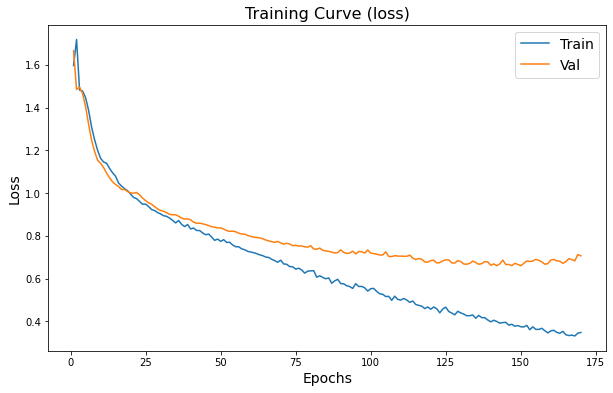

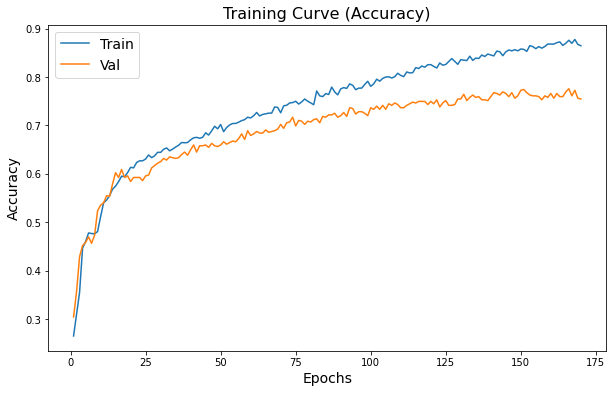

CUDA is available! Training on GPU ...
Epoch 1/170
Train loss:1.60456, Train Acc:0.2387
Val loss:1.61098, Val Acc:0.3044
time elapsed (s): 0.17
-----

Epoch 2/170
Train loss:1.64824, Train Acc:0.3081
Val loss:1.49879, Val Acc:0.2700
time elapsed (s): 0.11
-----

Epoch 3/170
Train loss:1.49407, Train Acc:0.2866
Val loss:1.49000, Val Acc:0.4255
time elapsed (s): 0.09
-----

Epoch 4/170
Train loss:1.46804, Train Acc:0.4574
Val loss:1.45544, Val Acc:0.4566
time elapsed (s): 0.10
-----

Epoch 5/170
Train loss:1.43335, Train Acc:0.4587
Val loss:1.38504, Val Acc:0.4746
time elapsed (s): 0.19
-----

Epoch 6/170
Train loss:1.36734, Train Acc:0.4599
Val loss:1.29786, Val Acc:0.4615
time elapsed (s): 0.11
-----

Epoch 7/170
Train loss:1.28958, Train Acc:0.4742
Val loss:1.22508, Val Acc:0.4697
time elapsed (s): 0.09
-----

Epoch 8/170
Train loss:1.23023, Train Acc:0.4802
Val loss:1.17885, Val Acc:0.4828
time elapsed (s): 0.10
-----

Epoch 9/170
Train loss:1.18527, Train Acc:0.4918
Val loss:1.15888

Train loss:0.65214, Train Acc:0.7480
Val loss:0.75995, Val Acc:0.6989
time elapsed (s): 0.08
-----

Epoch 76/170
Train loss:0.63426, Train Acc:0.7551
Val loss:0.75319, Val Acc:0.6956
time elapsed (s): 0.15
-----

Epoch 77/170
Train loss:0.65274, Train Acc:0.7439
Val loss:0.76176, Val Acc:0.6956
time elapsed (s): 0.08
-----

Epoch 78/170
Train loss:0.64550, Train Acc:0.7492
Val loss:0.74405, Val Acc:0.7070
time elapsed (s): 0.08
-----

Epoch 79/170
Train loss:0.63405, Train Acc:0.7498
Val loss:0.74583, Val Acc:0.7087
time elapsed (s): 0.09
-----

Epoch 80/170
Train loss:0.61676, Train Acc:0.7610
Val loss:0.75875, Val Acc:0.6989
time elapsed (s): 0.18
-----

Epoch 81/170
Train loss:0.62789, Train Acc:0.7592
Val loss:0.74234, Val Acc:0.7038
time elapsed (s): 0.10
-----

Epoch 82/170
Train loss:0.63039, Train Acc:0.7459
Val loss:0.74625, Val Acc:0.7103
time elapsed (s): 0.09
-----

Epoch 83/170
Train loss:0.61095, Train Acc:0.7625
Val loss:0.74390, Val Acc:0.7103
time elapsed (s): 0.10
---

Train loss:0.38066, Train Acc:0.8531
Val loss:0.65883, Val Acc:0.7643
time elapsed (s): 0.18
-----

Epoch 151/170
Train loss:0.37068, Train Acc:0.8595
Val loss:0.67302, Val Acc:0.7643
time elapsed (s): 0.08
-----

Epoch 152/170
Train loss:0.37809, Train Acc:0.8603
Val loss:0.66984, Val Acc:0.7545
time elapsed (s): 0.10
-----

Epoch 153/170
Train loss:0.37439, Train Acc:0.8576
Val loss:0.66499, Val Acc:0.7561
time elapsed (s): 0.10
-----

Epoch 154/170
Train loss:0.36642, Train Acc:0.8607
Val loss:0.69088, Val Acc:0.7496
time elapsed (s): 0.07
-----

Epoch 155/170
Train loss:0.36982, Train Acc:0.8590
Val loss:0.67790, Val Acc:0.7627
time elapsed (s): 0.15
-----

Epoch 156/170
Train loss:0.35107, Train Acc:0.8658
Val loss:0.68579, Val Acc:0.7480
time elapsed (s): 0.08
-----

Epoch 157/170
Train loss:0.36622, Train Acc:0.8642
Val loss:0.69990, Val Acc:0.7545
time elapsed (s): 0.06
-----

Epoch 158/170
Train loss:0.35749, Train Acc:0.8656
Val loss:0.68104, Val Acc:0.7529
time elapsed (s): 

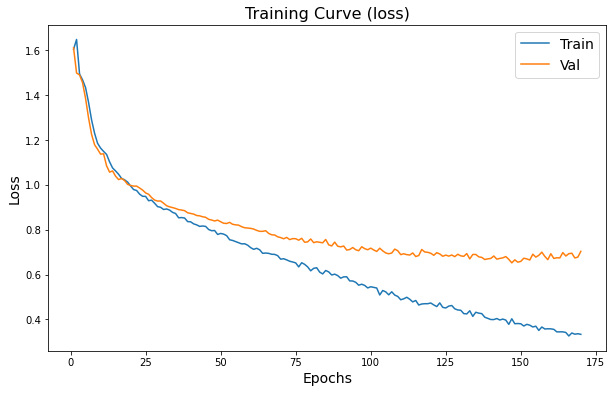

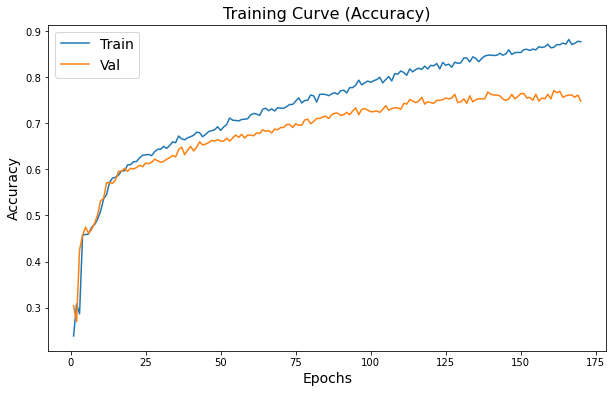

In [16]:
# Hyperparameters
loop = True # Continously train different models
name = 'RC5-4' # Remember to change net
layer1_size = 1024
layer2_size = 512
layer3_size = 1024
layer4_size = 512
num_class = 5 # Change
seed = 0 # Weight initialization
num_epochs = 170
b_size = None
lr = 0.001
dim = 128
criterion = nn.CrossEntropyLoss()
        
training_loader = {'train': loader(train_fts, train_labels,  b_size = b_size), 
                           'val': loader(val_fts, val_labels, b_size = b_size)}

# Looping for testing multiple hyperparameter values
if loop:
    seeds = [0, 59, 99, 199, 599, 999, 1999, 5999] 
#     b_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, None]
#     lrs = [0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1]
    for seed in seeds:                                        # change accordingly
#         for b_size in b_sizes:
#         net = ResNet_Classifier_1(name, layer1_size, layer2_size, num_class, seed) # default
#             training_loader = {'train': loader(train_fts, train_labels,  b_size = b_size), 
#                                'val': loader(val_fts, val_labels, b_size = b_size)}
#         net = ResNet_Classifier_2(name, layer1_size, layer2_size, layer3_size, num_class, seed) # +1 layer
#         net = ResNet_Classifier_3(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # +2 layers
#         net = ResNet_Classifier_4(name, layer1_size, layer2_size, num_class, seed) # drop out
        net = ResNet_Classifier_5(name, layer1_size, layer2_size, num_class, seed) # 2 drop out
#         net = ResNet_Classifier_6(name, layer1_size, layer2_size, num_class, seed) # 2 drop out + bn
#         net = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out
        optimizer = torch.optim.Adam(net.parameters(), lr = lr) 
        if use_cuda and torch.cuda.is_available():
            net.cuda()
            print('CUDA is available! Training on GPU ...')
        else:
            print('CUDA is unavailable. Training on CPU ...')
        file_path, keys = training(model = net, 
                                    dataloaders = training_loader, 
                                    criterion = criterion, 
                                    optimizer = optimizer, 
                                    num_epochs = num_epochs, 
                                    b_size = b_size, 
                                    lr = lr, 
                                    seed = seed, 
                                    dim = dim)
        print(file_path, keys)
        losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
        accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
        curve_plot(file_path, **losses)
        curve_plot(file_path, **accs)

else:
    net = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, i) # change
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('CUDA is available! Training on GPU ...')
    else:
        print('CUDA is unavailable. Training on CPU ...')  
    file_path, keys = training(model = net, 
                                dataloaders = training_loader, 
                                criterion = criterion, 
                                optimizer = optimizer, 
                                num_epochs = num_epochs, 
                                b_size = b_size, 
                                lr = lr, 
                                seed = seed,
                                dim = dim)
    print(file_path, keys)
    losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
    accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
    curve_plot(file_path, **losses)
    curve_plot(file_path, **accs)      
    

***=========================================================================================================***

### Training (Different Classes)

#### Top Pit: Combine classes 2 and 3 together

In [45]:
# Change all class 2 to 3
train_fts, train_labels = label_change(data = os.path.join(main_dir, 'train_resnet50_feat_tensors_64.pt'),
                                        labels = os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'),
                                        change = 2,
                                        value = 3)
print('\n')
val_fts, val_labels = label_change(data = os.path.join(main_dir, 'val_resnet50_feat_tensors_64.pt'),
                                        labels = os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'),
                                        change = 2,
                                        value = 3)

# Beware of overwritting
torch.save(train_labels, os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'))
torch.save(val_labels, os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'))

Label classes before: tensor([1, 2, 3, 4], dtype=torch.uint8)
Labels after: tensor([1, 3, 4], dtype=torch.uint8)
Labels after sequencing from 1: tensor([1, 2, 3], dtype=torch.uint8)


Label classes before: tensor([1, 2, 3, 4], dtype=torch.uint8)
Labels after: tensor([1, 3, 4], dtype=torch.uint8)
Labels after sequencing from 1: tensor([1, 2, 3], dtype=torch.uint8)


Total number of unique classes in data: 3
Class 1: 2,022 samples (23.5% of total)
Class 2: 4,990 samples (58.1% of total)
Class 3: 1,576 samples (18.4% of total)
Total number of tiles: 8588




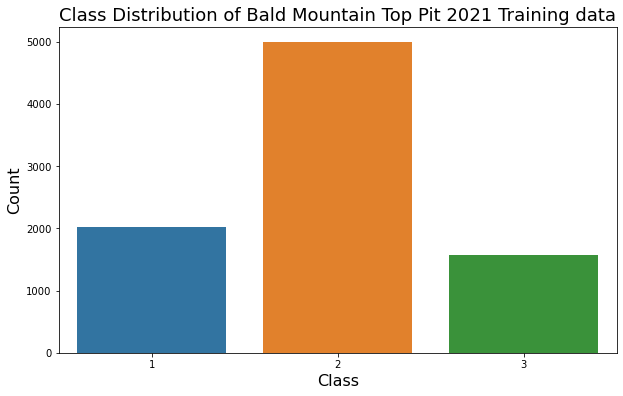

In [47]:
stats_plot(os.path.join(main_dir, 'train_tensors_64.pt'),
          os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'),
          'Training')

Total number of unique classes in data: 3
Class 1: 253 samples (23.6% of total)
Class 2: 624 samples (58.1% of total)
Class 3: 197 samples (18.3% of total)
Total number of tiles: 1074




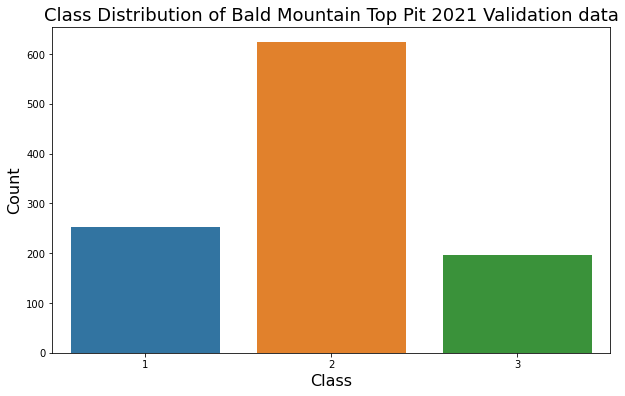

In [48]:
stats_plot(os.path.join(main_dir, 'val_tensors_64.pt'),
          os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'),
          'Validation')

In [16]:
# Load pre-computed feature data and preprocessed labels
train_fts = torch.load(os.path.join(main_dir, 'train_resnet50_feat_tensors_64.pt'))
_, train_labels = data_preproc(file_labels = os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'))

val_fts = torch.load(os.path.join(main_dir, 'val_resnet50_feat_tensors_64.pt'))
_, val_labels = data_preproc(file_labels = os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'))
print(train_fts.shape, train_labels.shape, val_fts.shape, val_labels.shape)

Labels subtracted by 1
Data preprocessing complete 

Labels subtracted by 1
Data preprocessing complete 

torch.Size([8588, 2048, 1, 1]) torch.Size([8588]) torch.Size([1074, 2048, 1, 1]) torch.Size([1074])


In [ ]:
# Hyperparameters
loop = True # Continously train different models
name = 'RC7-1' # Remember to change net
layer1_size = 1024
layer2_size = 1024
layer3_size = 1024
layer4_size = 512
num_class = 3 # Change
seed = 0 # Weight initialization
num_epochs = 75
b_size = None
lr = 0.001
dim = 64
criterion = nn.CrossEntropyLoss()
        
training_loader = {'train': loader(train_fts, train_labels,  b_size = b_size), 
                           'val': loader(val_fts, val_labels, b_size = b_size)}

# Looping for testing multiple hyperparameter values
if loop:
    seeds = [0, 59, 99, 199, 599, 999, 1999, 5999] 
#     b_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, None]
#     lrs = [0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1]
    for seed in seeds:                                        # change accordingly
#         net = ResNet_Classifier_1(name, layer1_size, layer2_size, num_class, seed) # default
#         training_loader = {'train': loader(train_fts, train_labels,  b_size = b_size), 
#                            'val': loader(val_fts, val_labels, b_size = b_size)}
#         net = ResNet_Classifier_2(name, layer1_size, layer2_size, layer3_size, num_class, seed) # +1 layer
#         net = ResNet_Classifier_3(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # +2 layers
#         net = ResNet_Classifier_4(name, layer1_size, layer2_size, num_class, seed) # drop out
#         net = ResNet_Classifier_5(name, layer1_size, layer2_size, num_class, seed) # 2 drop out
#         net = ResNet_Classifier_6(name, layer1_size, layer2_size, num_class, seed) # 2 drop out + bn
        net = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out
        optimizer = torch.optim.Adam(net.parameters(), lr = lr) 
        if use_cuda and torch.cuda.is_available():
            net.cuda()
            print('CUDA is available! Training on GPU ...')
        else:
            print('CUDA is unavailable. Training on CPU ...')
        file_path, keys = training(model = net, 
                                    dataloaders = training_loader, 
                                    criterion = criterion, 
                                    optimizer = optimizer, 
                                    num_epochs = num_epochs, 
                                    b_size = b_size, 
                                    lr = lr, 
                                    seed = seed, 
                                    dim = dim)
        print(file_path, keys)
        losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
        accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
        curve_plot(file_path, **losses)
        curve_plot(file_path, **accs)

else:
    net = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, i) # change
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('CUDA is available! Training on GPU ...')
    else:
        print('CUDA is unavailable. Training on CPU ...')  
    file_path, keys = training(model = net, 
                                dataloaders = training_loader, 
                                criterion = criterion, 
                                optimizer = optimizer, 
                                num_epochs = num_epochs, 
                                b_size = b_size, 
                                lr = lr, 
                                seed = seed,
                                dim = dim)
    print(file_path, keys)
    losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
    accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
    curve_plot(file_path, **losses)
    curve_plot(file_path, **accs)      
    

#### Pick Pit: Combine classes 1 and 3

In [50]:
# Change all class 1 to 3
train_fts, train_labels = label_change(data = os.path.join(main_dir, 'train_resnet50_feat_tensors_64.pt'),
                                        labels = os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'),
                                        change = 1,
                                        value = 3)
print('\n')
val_fts, val_labels = label_change(data = os.path.join(main_dir, 'val_resnet50_feat_tensors_64.pt'),
                                        labels = os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'),
                                        change = 1,
                                        value = 3)

# Beware of overwritting
torch.save(train_labels, os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'))
torch.save(val_labels, os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'))

Label classes before: tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
Labels after: tensor([0, 2, 3, 4], dtype=torch.uint8)
Labels after sequencing from 1: tensor([0, 1, 2, 3], dtype=torch.uint8)


Label classes before: tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
Labels after: tensor([0, 2, 3, 4], dtype=torch.uint8)
Labels after sequencing from 1: tensor([0, 1, 2, 3], dtype=torch.uint8)


Total number of unique classes in data: 4
Class 0: 2,108 samples (26.8% of total)
Class 1: 774 samples (9.8% of total)
Class 2: 3,711 samples (47.2% of total)
Class 3: 1,269 samples (16.1% of total)
Total number of tiles: 7862




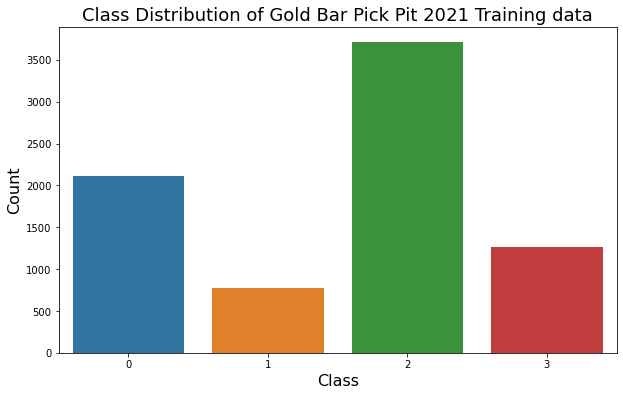

In [19]:
stats_plot(os.path.join(main_dir, 'train_tensors_64.pt'),
          os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'),
          'Training')

Total number of unique classes in data: 4
Class 0: 264 samples (26.9% of total)
Class 1: 97 samples (9.9% of total)
Class 2: 463 samples (47.1% of total)
Class 3: 159 samples (16.2% of total)
Total number of tiles: 983




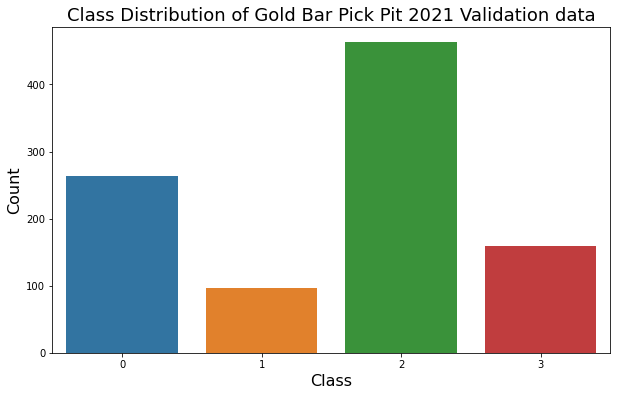

In [20]:
stats_plot(os.path.join(main_dir, 'val_tensors_64.pt'),
          os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'),
          'Validation')

In [30]:
# Load pre-computed feature data and preprocessed labels
train_fts = torch.load(os.path.join(main_dir, 'train_resnet50_feat_tensors_64.pt'))
_, train_labels = data_preproc(file_labels = os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'))

val_fts = torch.load(os.path.join(main_dir, 'val_resnet50_feat_tensors_64.pt'))
_, val_labels = data_preproc(file_labels = os.path.join(main_dir, 'val_tile_labels_tensors_64.pt'))
print(train_fts.shape, train_labels.shape, val_fts.shape, val_labels.shape)

Data preprocessing complete 

Data preprocessing complete 

torch.Size([7862, 2048, 1, 1]) torch.Size([7862]) torch.Size([983, 2048, 1, 1]) torch.Size([983])


In [ ]:
# Hyperparameters
loop = True # Continously train different models
name = 'RC7-1' # Remember to change net
layer1_size = 1024
layer2_size = 1024
layer3_size = 1024
layer4_size = 512
num_class = 4 # Change
seed = 0 # Weight initialization
num_epochs = 65
b_size = None
lr = 0.001
dim = 64
criterion = nn.CrossEntropyLoss()
        
training_loader = {'train': loader(train_fts, train_labels,  b_size = b_size), 
                           'val': loader(val_fts, val_labels, b_size = b_size)}

# Looping for testing multiple hyperparameter values
if loop:
    seeds = [0, 59, 99, 199, 599, 999, 1999, 5999] 
#     b_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, None]
#     lrs = [0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1]
    for seed in seeds:                                        # change accordingly
#         net = ResNet_Classifier_1(name, layer1_size, layer2_size, num_class, seed) # default
#         training_loader = {'train': loader(train_fts, train_labels,  b_size = b_size), 
#                            'val': loader(val_fts, val_labels, b_size = b_size)}
#         net = ResNet_Classifier_2(name, layer1_size, layer2_size, layer3_size, num_class, seed) # +1 layer
#         net = ResNet_Classifier_3(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # +2 layers
#         net = ResNet_Classifier_4(name, layer1_size, layer2_size, num_class, seed) # drop out
#         net = ResNet_Classifier_5(name, layer1_size, layer2_size, num_class, seed) # 2 drop out
#         net = ResNet_Classifier_6(name, layer1_size, layer2_size, num_class, seed) # 2 drop out + bn
        net = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out
        optimizer = torch.optim.Adam(net.parameters(), lr = lr) 
        if use_cuda and torch.cuda.is_available():
            net.cuda()
            print('CUDA is available! Training on GPU ...')
        else:
            print('CUDA is unavailable. Training on CPU ...')
        file_path, keys = training(model = net, 
                                    dataloaders = training_loader, 
                                    criterion = criterion, 
                                    optimizer = optimizer, 
                                    num_epochs = num_epochs, 
                                    b_size = b_size, 
                                    lr = lr, 
                                    seed = seed, 
                                    dim = dim)
        print(file_path, keys)
        losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
        accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
        curve_plot(file_path, **losses)
        curve_plot(file_path, **accs)

else:
    net = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, i) # change
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('CUDA is available! Training on GPU ...')
    else:
        print('CUDA is unavailable. Training on CPU ...')  
    file_path, keys = training(model = net, 
                                dataloaders = training_loader, 
                                criterion = criterion, 
                                optimizer = optimizer, 
                                num_epochs = num_epochs, 
                                b_size = b_size, 
                                lr = lr, 
                                seed = seed,
                                dim = dim)
    print(file_path, keys)
    losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
    accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
    curve_plot(file_path, **losses)
    curve_plot(file_path, **accs)      
    

## Method 2: Finetuning

***Sanity check***

In [97]:
# # Work with small sample first to test
# data, labels = data_preproc(os.path.join(main_dir, 'train_tensors_64.pt'), 
#             os.path.join(main_dir, 'train_tensors_64.pt'), 
#                             os.path.join(main_dir, 'train_tile_labels_tensors_64.pt'))
# print(data.shape)
# print(labels.shape)

Mean values of the three channels are: tensor([138.9442, 127.4266, 109.7541])
Stdev values of the three channels are: tensor([27.5173, 31.1703, 33.5560])

Mean values of the three channels after input normalization are: tensor([-5.6080e-07, -1.0934e-07,  3.3661e-08])
Stdev values of the three channels after input normalization are: tensor([1.0000, 1.0000, 1.0000])

Labels subtracted by 1
Data preprocessing complete 

torch.Size([8588, 3, 64, 64])
torch.Size([8588])


In [98]:
# indices = torch.randperm(data.shape[0]) # Randomly create indices
# # Get 30 samples for training and validation subset
# subset_train_data = data[indices[:30]]
# subset_train_labels = labels[indices[:30]]
# subset_val_data = data[indices[-30:]]
# subset_val_labels = labels[indices[-30:]]

# net = resnet50(pretrained = True)
# net.fc = ResNet_Classifier_1('sanity-check', 1024, 512, 4, 666)
# for module in net.modules():
#     if isinstance(module, nn.BatchNorm2d):
#         module.eval()   
        
# subset_loader = {'train': loader(subset_train_data, subset_train_labels), 
#                  'val': loader(subset_val_data, subset_val_labels)}
# print(summary(net))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [99]:
# if use_cuda and torch.cuda.is_available():
#     net.cuda()
#     print('CUDA is available! Training on GPU ...')
# else:
#     print('CUDA is unavailable. Training on CPU ...')   
    
# file_path, keys = training(model = net, 
#                             dataloaders = subset_loader, 
#                             criterion = nn.CrossEntropyLoss(), 
#                             optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001), 
#                             num_epochs = 10, 
#                             b_size = subset_train_data.shape[0], 
#                             lr = 0.0001, 
#                             seed = 666,
#                           dim = 64,
#                           name = 'sanity-check')

CUDA is available! Training on GPU ...
Epoch 1/10
Train loss:1.39499, Train Acc:0.2333
Val loss:1.35634, Val Acc:0.3333
time elapsed (s): 2.08
-----

Epoch 2/10
Train loss:1.22538, Train Acc:0.8000
Val loss:1.34160, Val Acc:0.4667
time elapsed (s): 0.09
-----

Epoch 3/10
Train loss:1.06892, Train Acc:1.0000
Val loss:1.32233, Val Acc:0.4667
time elapsed (s): 0.08
-----

Epoch 4/10
Train loss:0.91809, Train Acc:1.0000
Val loss:1.30198, Val Acc:0.4667
time elapsed (s): 0.06
-----

Epoch 5/10
Train loss:0.78239, Train Acc:1.0000
Val loss:1.28102, Val Acc:0.4667
time elapsed (s): 0.05
-----

Epoch 6/10
Train loss:0.65677, Train Acc:1.0000
Val loss:1.26085, Val Acc:0.4667
time elapsed (s): 0.05
-----

Epoch 7/10
Train loss:0.54513, Train Acc:1.0000
Val loss:1.24576, Val Acc:0.4667
time elapsed (s): 0.05
-----

Epoch 8/10
Train loss:0.44446, Train Acc:1.0000
Val loss:1.23612, Val Acc:0.4667
time elapsed (s): 0.06
-----

Epoch 9/10
Train loss:0.35331, Train Acc:1.0000
Val loss:1.22966, Val Acc

In [100]:
# print(file_path)
# print(keys)
# subset_loss = load_loss_acc(file_path, 'train_losses', 'val_losses')
# subset_acc = load_loss_acc(file_path, 'train_acc', 'val_acc')

Top_2021_Model_sanity-check_dim64_bs30_s666_lr0.0001_epoch10_of_10
['train_losses', 'train_acc', 'val_losses', 'val_acc']
train_losses loaded
val_losses loaded
train_acc loaded
val_acc loaded


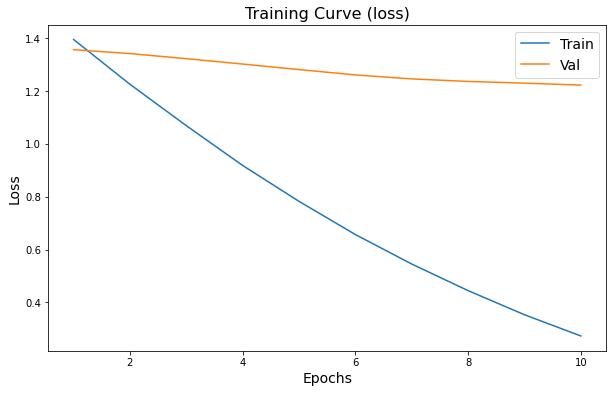

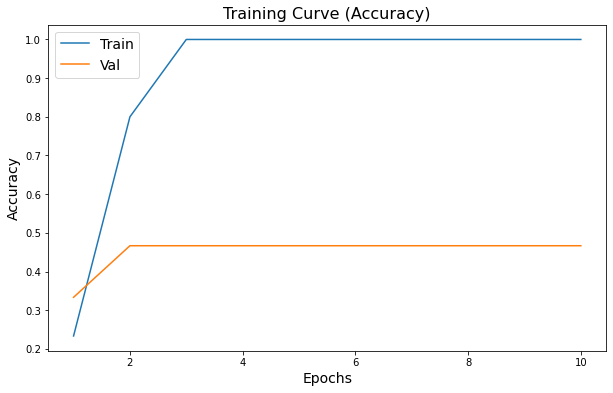

In [101]:
# curve_plot(file_path, **subset_loss)
# curve_plot(file_path, **subset_acc)

In [103]:
# t = check_point('sanity-check', 64, 30, 666, 0.0001, 1, 10)
# net.load_state_dict( torch.load(os.path.join(main_dir, t) + '.pt') )

<All keys matched successfully>

***=========================================================================================================***

### Training (Default Classes)

Use the chosen models from feature extraction section for finetuning

In [14]:
# Load pre-computed feature data and preprocessed labels
dim = 96
train_data, train_labels = data_preproc(norm_file = os.path.join(main_dir, 'train_tensors_{}.pt'.format(dim)), 
                                        file = os.path.join(main_dir, 'train_tensors_{}.pt'.format(dim)),
                                       file_labels = os.path.join(main_dir, 'train_tile_labels_tensors_{}.pt'.format(dim)))

val_data, val_labels = data_preproc(norm_file = os.path.join(main_dir, 'train_tensors_{}.pt'.format(dim)), 
                                        file = os.path.join(main_dir, 'val_tensors_{}.pt'.format(dim)),
                                          file_labels = os.path.join(main_dir, 'val_tile_labels_tensors_{}.pt'.format(dim)))

print(train_data.shape, train_labels.shape, val_data.shape, val_labels.shape)

Mean values of the three channels are: tensor([128.6827, 117.1942, 104.6447])
Stdev values of the three channels are: tensor([21.6555, 22.0790, 21.9162])

Mean values of the three channels after input normalization are: tensor([-3.1740e-08, -7.7751e-09,  1.3972e-07])
Stdev values of the three channels after input normalization are: tensor([1., 1., 1.])

Data preprocessing complete 

Mean values of the three channels are: tensor([128.6827, 117.1942, 104.6447])
Stdev values of the three channels are: tensor([21.6555, 22.0790, 21.9162])

Mean values of the three channels after input normalization are: tensor([0.0252, 0.0196, 0.0191])
Stdev values of the three channels after input normalization are: tensor([1.0141, 1.0174, 1.0199])

Data preprocessing complete 

torch.Size([6460, 3, 96, 96]) torch.Size([6460]) torch.Size([808, 3, 96, 96]) torch.Size([808])


#### Top Pit (Default classes)

CUDA is available! Training on GPU ...
Epoch 1/10
Train loss:0.42297, Train Acc:0.8652
Val loss:0.16360, Val Acc:0.9470
time elapsed (s): 8.51
-----

Epoch 2/10
Train loss:0.16446, Train Acc:0.9420
Val loss:0.13571, Val Acc:0.9455
time elapsed (s): 8.14
-----

Epoch 3/10
Train loss:0.10993, Train Acc:0.9600
Val loss:0.13774, Val Acc:0.9530
time elapsed (s): 8.20
-----

Epoch 4/10
Train loss:0.07867, Train Acc:0.9722
Val loss:0.11996, Val Acc:0.9591
time elapsed (s): 8.16
-----

Epoch 5/10
Train loss:0.05247, Train Acc:0.9814
Val loss:0.10574, Val Acc:0.9636
time elapsed (s): 8.19
-----

Epoch 6/10
Train loss:0.04149, Train Acc:0.9858
Val loss:0.12217, Val Acc:0.9667
time elapsed (s): 8.20
-----

Epoch 7/10
Train loss:0.02573, Train Acc:0.9909
Val loss:0.09947, Val Acc:0.9742
time elapsed (s): 8.17
-----

Epoch 8/10
Train loss:0.01802, Train Acc:0.9939
Val loss:0.13436, Val Acc:0.9697
time elapsed (s): 8.16
-----

Epoch 9/10
Train loss:0.02097, Train Acc:0.9934
Val loss:0.12932, Val Acc

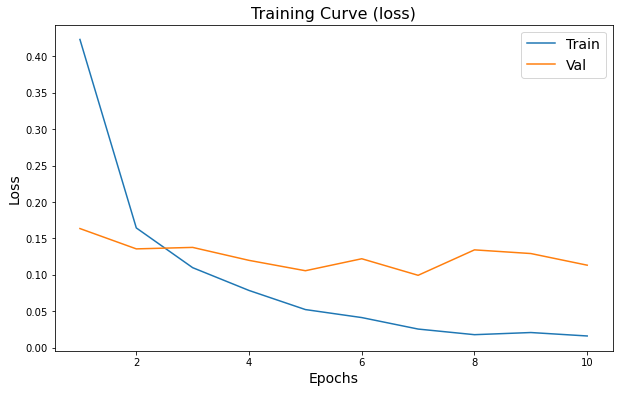

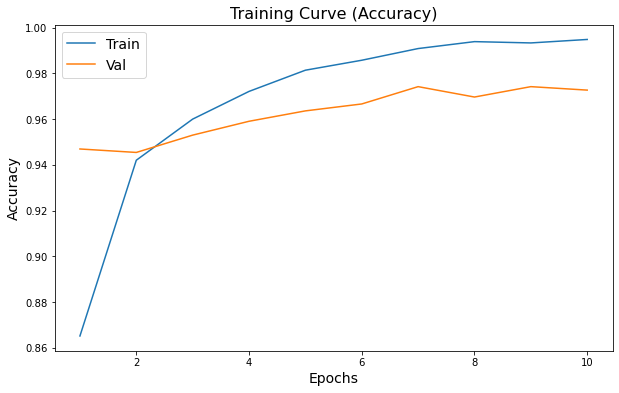

In [25]:
# Hyperparameters
params = 'Top_2021_Model_RC7-3_dim128_bsNone_s199_lr0.001_epoch119_of_140.pt' # change
layer1_size = 1024 # change
layer2_size = 1024 # change
layer3_size = 1024 # change
layer4_size = 512 # change
num_class = 4 # Change
unfreeze = None # Resnet layer to train (None = all)
num_epochs = 10 # change
b_size = 256 # change
lr = 3e-5 # change
loop = False # Continously train different models

seed = params.split('_')[6][1:] # Weight initialization
if unfreeze is not None:
    name = params.split('_')[3] + 'FT' + unfreeze # Differentiate from feature extraction version
else:
    name = params.split('_')[3] + 'FT'
dim = int(params.split('_')[4][3:])
criterion = nn.CrossEntropyLoss()    

# Looping for testing multiple hyperparameter values
if loop:
    training_loader = None
#     b_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
#     lrs = [1e-6, 1e-5, 1e-4, 0.001, 0.003]  
    b_sizes = [256]
    lrs = [1e-4, 3e-5, 3e-6]
    for b_size in b_sizes:  # change accordingly
        training_loader = {'train': loader(train_data, train_labels,  b_size = b_size), 
                                   'val': loader(val_data, val_labels, b_size = b_size)}
        for lr in lrs:            
            ##### Network settings #####
            net = resnet50(pretrained = True)
            if unfreeze is not None:
                # Train selected layer                
                for named, param in net.named_parameters():
                    if unfreeze in named:
                        param.requires_grad = True # Unfreeze layers to be trained (should all be True by default)
                    else:
                        param.requires_grad = False # Freeze all other layers
                # Replace Resnet classifier with trained custom classifier
#                 net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)  
#                 net.fc = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, seed)  
                net.fc = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out
                
            else: # Train all layers
#                 net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)
#                 net.fc = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, seed)
                net.fc = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out        
            
            # Load trained classifier weights
            net.fc.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
            ##############################
            if use_cuda and torch.cuda.is_available():
                net.cuda()
                print('CUDA is available! Training on GPU ...')
            else:
                print('CUDA is unavailable. Training on CPU ...')
            optimizer = torch.optim.Adam(net.parameters(), lr = lr) 
            file_path, keys = training(model = net, 
                                        dataloaders = training_loader, 
                                        criterion = criterion, 
                                        optimizer = optimizer, 
                                        num_epochs = num_epochs, 
                                        b_size = b_size, 
                                        lr = lr, 
                                        seed = seed, 
                                        dim = dim,
                                      name = name,
                                      bn2_freeze = True)
            print(file_path, keys)
            losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
            accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
            curve_plot(file_path, **losses)
            curve_plot(file_path, **accs)

else:    
    training_loader = {'train': loader(train_data, train_labels,  b_size = b_size), 
                               'val': loader(val_data, val_labels, b_size = b_size)}
    ##### Network settings #####
    net = resnet50(pretrained = True)
    if unfreeze is not None:
        # Train selected layer                
        for named, param in net.named_parameters():
            if unfreeze in named:
                param.requires_grad = True # Unfreeze layers to be trained (should all be True by default)
            else:
                param.requires_grad = False # Freeze all other layers
        # Replace Resnet classifier with trained custom classifier
#         net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)  
        net.fc = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out
        
    else: # Train all layers
        net.fc = ResNet_Classifier_7(name, layer1_size, layer2_size, layer3_size, layer4_size, num_class, seed) # 2 drop out
#         net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)

    net.fc.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
    ##############################
    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('CUDA is available! Training on GPU ...')
    else:
        print('CUDA is unavailable. Training on CPU ...')  
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    file_path, keys = training(model = net, 
                                dataloaders = training_loader, 
                                criterion = criterion, 
                                optimizer = optimizer, 
                                num_epochs = num_epochs, 
                                b_size = b_size, 
                                lr = lr, 
                                seed = seed,
                                dim = dim,
                              name = name,
                              bn2_freeze = True)
    print(file_path, keys)
    losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
    accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
    curve_plot(file_path, **losses)
    curve_plot(file_path, **accs)      
    

#### Pick Pit (Default classes)

CUDA is available! Training on GPU ...
Epoch 1/15
Train loss:2.45693, Train Acc:0.4310
Val loss:1.15589, Val Acc:0.5087
time elapsed (s): 6.35
-----

Epoch 2/15
Train loss:1.11851, Train Acc:0.5337
Val loss:0.97653, Val Acc:0.6052
time elapsed (s): 6.05
-----

Epoch 3/15
Train loss:0.98755, Train Acc:0.6039
Val loss:0.93273, Val Acc:0.6275
time elapsed (s): 6.06
-----

Epoch 4/15
Train loss:0.93042, Train Acc:0.6286
Val loss:0.88889, Val Acc:0.6423
time elapsed (s): 6.18
-----

Epoch 5/15
Train loss:0.85476, Train Acc:0.6621
Val loss:0.85293, Val Acc:0.6819
time elapsed (s): 6.07
-----

Epoch 6/15
Train loss:0.80797, Train Acc:0.6791
Val loss:0.82683, Val Acc:0.6819
time elapsed (s): 6.06
-----

Epoch 7/15
Train loss:0.75617, Train Acc:0.6969
Val loss:0.76854, Val Acc:0.7129
time elapsed (s): 6.07
-----

Epoch 8/15
Train loss:0.73868, Train Acc:0.7096
Val loss:0.82008, Val Acc:0.6646
time elapsed (s): 6.08
-----

Epoch 9/15
Train loss:0.70779, Train Acc:0.7207
Val loss:0.75750, Val Acc

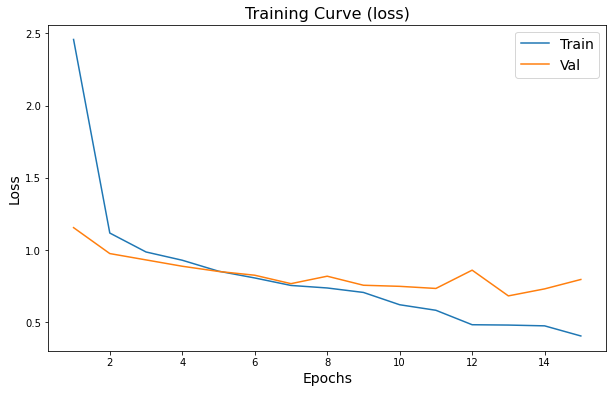

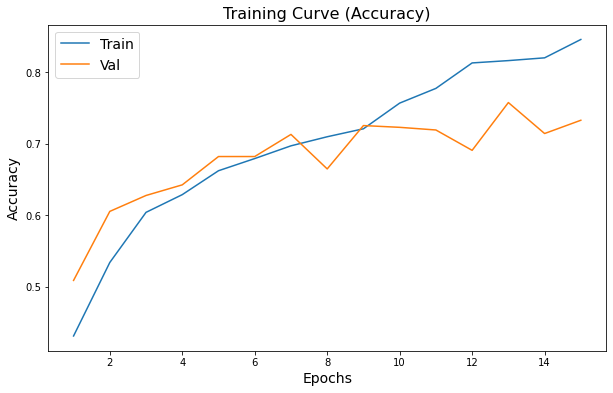

In [16]:
# Hyperparameters
params = 'Pick_2021_Model_RC5-4_dim96_bsNone_s59_lr0.001_epoch146_of_150.pt' # change
layer1_size = 1024 # change
layer2_size = 512 # change
# layer3_size = 512 # change
# layer4_size = 1024 # change
num_class = 5 # Change
unfreeze = None # Resnet layer to train (None = all)
num_epochs = 15 # change
b_size = 512 # change
lr = 1e-4 # change
loop = False # Continously train different models

seed = params.split('_')[6][1:] # Weight initialization
if unfreeze is not None:
    name = params.split('_')[3] + 'FT' + unfreeze # Differentiate from feature extraction version
else:
    name = params.split('_')[3] + 'FT'
dim = int(params.split('_')[4][3:])
criterion = nn.CrossEntropyLoss()    

# Looping for testing multiple hyperparameter values
if loop:
    training_loader = None
#     b_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
#     lrs = [1e-6, 1e-5, 1e-4, 0.001, 0.003]   
    b_sizes = [512]
    lrs = [1e-4, 3e-5, 3e-6]
    for b_size in b_sizes:  # change accordingly
        training_loader = {'train': loader(train_data, train_labels,  b_size = b_size), 
                                   'val': loader(val_data, val_labels, b_size = b_size)}
        for lr in lrs:            
            ##### Network settings #####
            net = resnet50(pretrained = True)
            if unfreeze is not None:
                # Train selected layer                
                for named, param in net.named_parameters():
                    if unfreeze in named:
                        param.requires_grad = True # Unfreeze layers to be trained (should all be True by default)
                    else:
                        param.requires_grad = False # Freeze all other layers
                # Replace Resnet classifier with trained custom classifier
#                 net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)  
#                 net.fc = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, seed)  
                net.fc = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, seed)                 
                
            else: # Train all layers
#                 net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)
                net.fc = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, seed)               
#                 net.fc = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, seed)
            
            # Load trained classifier weights
            net.fc.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
            ##############################
            if use_cuda and torch.cuda.is_available():
                net.cuda()
                print('CUDA is available! Training on GPU ...')
            else:
                print('CUDA is unavailable. Training on CPU ...')
            optimizer = torch.optim.Adam(net.parameters(), lr = lr) 
            file_path, keys = training(model = net, 
                                        dataloaders = training_loader, 
                                        criterion = criterion, 
                                        optimizer = optimizer, 
                                        num_epochs = num_epochs, 
                                        b_size = b_size, 
                                        lr = lr, 
                                        seed = seed, 
                                        dim = dim,
                                      name = name,
                                      bn2_freeze = True)
            print(file_path, keys)
            losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
            accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
            curve_plot(file_path, **losses)
            curve_plot(file_path, **accs)

else:    
    training_loader = {'train': loader(train_data, train_labels,  b_size = b_size), 
                               'val': loader(val_data, val_labels, b_size = b_size)}
    ##### Network settings #####
    net = resnet50(pretrained = True)
    if unfreeze is not None:
        # Train selected layer                
        for named, param in net.named_parameters():
            if unfreeze in named:
                param.requires_grad = True # Unfreeze layers to be trained (should all be True by default)
            else:
                param.requires_grad = False # Freeze all other layers
        # Replace Resnet classifier with trained custom classifier
#         net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)    
        net.fc = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, seed)                 
    
    else: # Train all layers
#         net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, seed)
        net.fc = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, seed)                 
        

    net.fc.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
    ##############################
    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('CUDA is available! Training on GPU ...')
    else:
        print('CUDA is unavailable. Training on CPU ...')  
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    file_path, keys = training(model = net, 
                                dataloaders = training_loader, 
                                criterion = criterion, 
                                optimizer = optimizer, 
                                num_epochs = num_epochs, 
                                b_size = b_size, 
                                lr = lr, 
                                seed = seed,
                                dim = dim,
                              name = name,
                              bn2_freeze = True)
    print(file_path, keys)
    losses = load_loss_acc(file_path, 'train_losses', 'val_losses')
    accs = load_loss_acc(file_path, 'train_acc', 'val_acc')
    curve_plot(file_path, **losses)
    curve_plot(file_path, **accs)      
    

***=========================================================================================================***

## For feature extraction method: Choosing Models for Testing

In [21]:
# Take the txt files containing val acc and output the file name and its highest val acc (with the epoch number)
file_path = os.path.join(main_dir, '128x128/RC5-4 (1024-512) drop') # change
val_acc_f = [f.replace('_val_acc.txt', '') for f in os.listdir(file_path) if 'val_acc' in f]
val_acc_f.sort(key = len)

highest = {'model': '', 'value': 0., 'epoch': 0}
for acc_f in val_acc_f:
    acc_values = load_loss_acc(os.path.join(file_path, acc_f), 'val_acc')
    max_value = max(acc_values['val_acc'])
    max_value_ind = acc_values['val_acc'].index(max_value) # List index from 0, NOT 1
    if max_value > highest['value']:
        highest['value'] = max_value
        highest['model'] = acc_f
        highest['epoch'] = max_value_ind
    print('For {}:'.format(acc_f))
    print('Max val acc is {:.3f} at epoch {}'.format(max_value, max_value_ind))      
    print('')
print('Highest accuracy overall is {:.3f} at epoch {} in model {}'.format(highest['value'],
                                                                              highest['epoch'],
                                                                              highest['model']))

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s0_lr0.001_epoch170_of_170:
Max val acc is 0.773 at epoch 169

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s59_lr0.001_epoch170_of_170:
Max val acc is 0.766 at epoch 159

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s99_lr0.001_epoch170_of_170:
Max val acc is 0.769 at epoch 145

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s199_lr0.001_epoch170_of_170:
Max val acc is 0.777 at epoch 152

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s599_lr0.001_epoch170_of_170:
Max val acc is 0.771 at epoch 158

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s999_lr0.001_epoch170_of_170:
Max val acc is 0.776 at epoch 165

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s1999_lr0.001_epoch170_of_170:
Max val acc is 0.776 at epoch 165

val_acc loaded
For Pick_2021_Model_RC5-4_dim128_bsNone_s5999_lr0.001_epoch170_of_170:
Max val acc is 0.771 at epoch 160

Highest accuracy overall is 0.777 at epoch

***=========================================================================================================***

## Feature Extraction Method: Plotting Models Training Curve

val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded


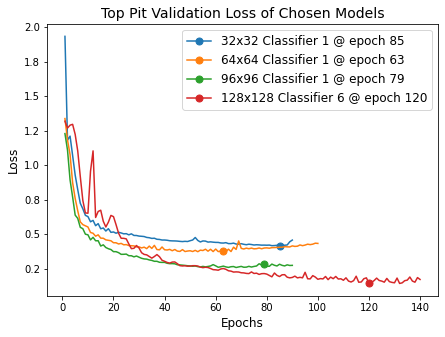

val_acc loaded
val_acc loaded
val_acc loaded
val_acc loaded


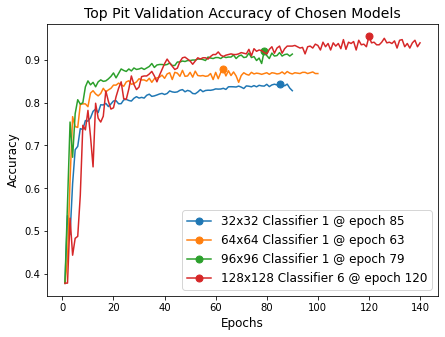

In [62]:
# Selected models for testing
# BM
from matplotlib.ticker import FormatStrFormatter
dim_32_path = os.path.join(main_dir, 
    r'32x32\RC1-1 (1024-512)\Top_2021_Model_RC1-1_dim32_bsNone_s59_lr0.001_epoch90_of_90')

dim_64_path = os.path.join(main_dir,
    r'64x64\Default classes\RC1-5 (1024-512)\Top_2021_Model_RC1-5_dim64_bsNone_s599_lr0.001_epoch100_of_100')

dim_96_path = os.path.join(main_dir,
    r'96x96\aug\RC1-3 (1024-512)\Top_2021_Model_RC1-3_dim96_bsNone_s5999_lr0.001_epoch90_of_90')

dim_128_path = os.path.join(main_dir,
    r'128x128\RC7-3 (1024-1024-1024-512) drop\Top_2021_Model_RC7-3_dim128_bsNone_s199_lr0.001_epoch140_of_140')

files_path = {'32x32 Classifier 1': dim_32_path, 
              '64x64 Classifier 1': dim_64_path,
              '96x96 Classifier 1': dim_96_path,
              '128x128 Classifier 6': dim_128_path} # 7 in code, 6 in thesis
marker_at = {'32x32 Classifier 1': [84], '64x64 Classifier 1': [62], 
             '96x96 Classifier 1': [78], '128x128 Classifier 6': [119]} # 7 in code, 6 in thesis
###############################################################################

# Plot validation accuracies and losses for selected models
fig, ax = plt.subplots(figsize = (7, 5))
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_losses')
    plt.plot(range(1, len(losses['val_losses'])+1), losses['val_losses'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
plt.title('Top Pit Validation Loss of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show();  

plt.figure(figsize = (7, 5)) 
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_acc')
    plt.plot(range(1, len(losses['val_acc'])+1), losses['val_acc'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Accuracy', fontsize = 12)
plt.title('Top Pit Validation Accuracy of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
plt.show();    

val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded


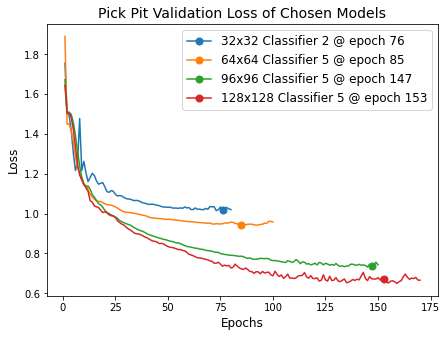

val_acc loaded
val_acc loaded
val_acc loaded
val_acc loaded


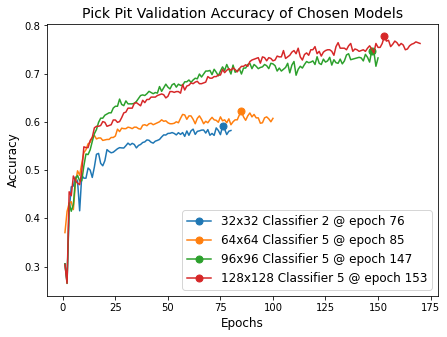

In [60]:
# Selected models for testing
# GB
dim_32_path = os.path.join(main_dir, 
    r'32x32\RC2-2 (1024-1024-512)\Pick_2021_Model_RC2-2_dim32_bsNone_s5999_lr0.001_epoch80_of_80')

dim_64_path = os.path.join(main_dir,
    r'64x64\Default classes\RC5-3 (1024-512) drop\Pick_2021_Model_RC5-3_dim64_bsNone_s5999_lr0.001_epoch100_of_100')

dim_96_path = os.path.join(main_dir,
    r'96x96\aug\RC5-4 (1024-512) drop\Pick_2021_Model_RC5-4_dim96_bsNone_s59_lr0.001_epoch150_of_150')

dim_128_path = os.path.join(main_dir,
    r'128x128\RC5-4 (1024-512) drop\Pick_2021_Model_RC5-4_dim128_bsNone_s199_lr0.001_epoch170_of_170')

files_path = {'32x32 Classifier 2': dim_32_path, '64x64 Classifier 5': dim_64_path, 
              '96x96 Classifier 5': dim_96_path, '128x128 Classifier 5': dim_128_path}
marker_at = {'32x32 Classifier 2': [75], '64x64 Classifier 5': [84], 
             '96x96 Classifier 5': [146], '128x128 Classifier 5': [152]}

# Plot validation accuracies and losses for selected models
plt.figure(figsize = (7, 5)) 

for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_losses')
    plt.plot(range(1, len(losses['val_losses'])+1), losses['val_losses'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
plt.title('Pick Pit Validation Loss of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
plt.show();    

plt.figure(figsize = (7, 5)) 
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_acc')
    plt.plot(range(1, len(losses['val_acc'])+1), losses['val_acc'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Accuracy', fontsize = 12)
plt.title('Pick Pit Validation Accuracy of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
plt.show();  

## Finetuning Method: Plotting Models Training Curve

val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded


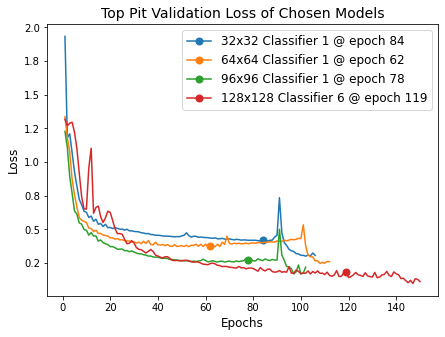

val_acc loaded
val_acc loaded
val_acc loaded
val_acc loaded


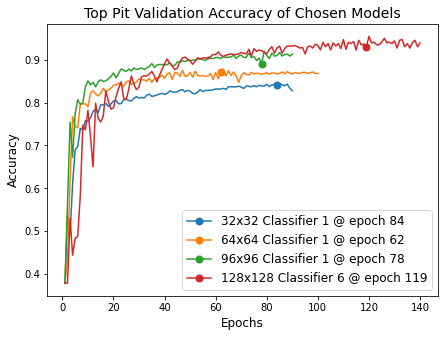

In [19]:
# # Combined
# # Finetune
# dim_32_path_ft = os.path.join(main_dir, 
#     r'32x32\RC1-1FT all lr\Top_2021_Model_RC1-1FT_dim32_bs4096_s59_lr9e-05_epoch16_of_16')

# dim_64_path_ft = os.path.join(main_dir,
#     r'64x64\Default classes\RC1-5FT all\Top_2021_Model_RC1-5FT_dim64_bs1024_s599_lr9e-05_epoch12_of_12')

# dim_96_path_ft = os.path.join(main_dir,
#     r'96x96\aug\RC1-3FT all\Top_2021_Model_RC1-3FT_dim96_bs512_s5999_lr9e-05_epoch12_of_12')

# dim_128_path_ft = os.path.join(main_dir,
#     r'128x128\RC7-3FT all epoch\Top_2021_Model_RC7-3FT_dim128_bs256_s199_lr3e-05_epoch10_of_10')

# files_path_ft = {'32x32 Classifier 1': dim_32_path_ft, '64x64 Classifier 1': dim_64_path_ft, 
#               '96x96 Classifier 1': dim_96_path_ft, '128x128 Classifier 6': dim_128_path_ft} # 7 in code, 6 in thesis
# # marker_at_ft = {'32x32 Classifier 1': [11], '64x64 Classifier 1': [11], 
# #              '96x96 Classifier 1': [9], '128x128 Classifier 6': [6]} # 7 in code, 6 in thesis

# # Pre-finetune
# dim_32_path = os.path.join(main_dir, 
#     r'32x32\RC1-1 (1024-512)\Top_2021_Model_RC1-1_dim32_bsNone_s59_lr0.001_epoch90_of_90')

# dim_64_path = os.path.join(main_dir,
#     r'64x64\Default classes\RC1-5 (1024-512)\Top_2021_Model_RC1-5_dim64_bsNone_s599_lr0.001_epoch100_of_100')

# dim_96_path = os.path.join(main_dir,
#     r'96x96\aug\RC1-3 (1024-512)\Top_2021_Model_RC1-3_dim96_bsNone_s5999_lr0.001_epoch90_of_90')

# dim_128_path = os.path.join(main_dir,
#     r'128x128\RC7-3 (1024-1024-1024-512) drop\Top_2021_Model_RC7-3_dim128_bsNone_s199_lr0.001_epoch140_of_140')

# files_path = {'32x32 Classifier 1': dim_32_path, 
#               '64x64 Classifier 1': dim_64_path,
#               '96x96 Classifier 1': dim_96_path,
#               '128x128 Classifier 6': dim_128_path} # 7 in code, 6 in thesis
# marker_at = {'32x32 Classifier 1': [84, 84+11], '64x64 Classifier 1': [62, 62+11], 
#              '96x96 Classifier 1': [78, 78+9], '128x128 Classifier 6': [119, 119+6]} # 7 in code, 6 in thesis

# # Plot validation accuracies and losses for selected models
# fig, ax = plt.subplots(figsize = (7, 5))
# for (dim, file_path), (_, file_path_ft) in zip(files_path.items(), files_path_ft.items()):
#     losses = load_loss_acc(file_path, 'val_losses')
#     losses_ft = load_loss_acc(file_path_ft, 'val_losses')
#     plt.plot(range(1, len(losses['val_losses'] + losses_ft['val_losses'])+1), 
#              losses['val_losses'] + losses_ft['val_losses'], marker = 'o', markersize = 7,
#              markevery = marker_at[dim], label = '{} @ epoch {}'.format(dim, [m + 1 for m in marker_at[dim]]))
                                                                        
#     plt.xlabel('Epochs', fontsize = 12)
#     plt.ylabel('Loss', fontsize = 12)
# plt.title('Top Pit Validation Loss of Chosen Models', fontsize = 14)
# plt.legend(fontsize = 12)
# plt.show();  

# # plt.figure(figsize = (7, 5)) 
# # for dim, file_path in files_path.items():
# #     losses = load_loss_acc(file_path, 'val_acc')
# #     plt.plot(range(1, len(losses['val_acc'])+1), losses['val_acc'], marker = 'o', markersize = 7,
# #              markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
# #     plt.xlabel('Epochs', fontsize = 12)
# #     plt.ylabel('Accuracy', fontsize = 12)
# # plt.title('Top Pit Validation Accuracy of Chosen Models', fontsize = 14)
# # plt.legend(fontsize = 12)
# # plt.show();    

val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded


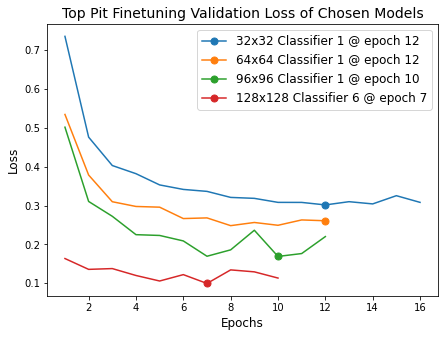

val_acc loaded
val_acc loaded
val_acc loaded
val_acc loaded


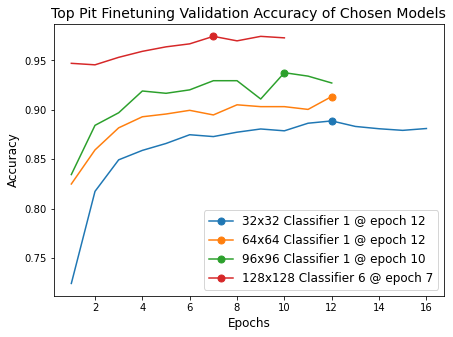

In [75]:
# Selected models for testing
# BM
from matplotlib.ticker import FormatStrFormatter
dim_32_path = os.path.join(main_dir, 
    r'32x32\RC1-1FT all lr\Top_2021_Model_RC1-1FT_dim32_bs4096_s59_lr9e-05_epoch16_of_16')

dim_64_path = os.path.join(main_dir,
    r'64x64\Default classes\RC1-5FT all\Top_2021_Model_RC1-5FT_dim64_bs1024_s599_lr9e-05_epoch12_of_12')

dim_96_path = os.path.join(main_dir,
    r'96x96\aug\RC1-3FT all\Top_2021_Model_RC1-3FT_dim96_bs512_s5999_lr9e-05_epoch12_of_12')

dim_128_path = os.path.join(main_dir,
    r'128x128\RC7-3FT all epoch\Top_2021_Model_RC7-3FT_dim128_bs256_s199_lr3e-05_epoch10_of_10')

files_path = {'32x32 Classifier 1': dim_32_path, '64x64 Classifier 1': dim_64_path, 
              '96x96 Classifier 1': dim_96_path, '128x128 Classifier 6': dim_128_path} # 7 in code, 6 in thesis
marker_at = {'32x32 Classifier 1': [11], '64x64 Classifier 1': [11], 
             '96x96 Classifier 1': [9], '128x128 Classifier 6': [6]} # 7 in code, 6 in thesis
###############################################################################

# Plot validation accuracies and losses for selected models
plt.figure(figsize = (7, 5)) 
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_losses')
    plt.plot(range(1, len(losses['val_losses'])+1), losses['val_losses'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
plt.title('Top Pit Finetuning Validation Loss of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show();  

fig, ax = plt.subplots(figsize = (7, 5)) 
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_acc')
    plt.plot(range(1, len(losses['val_acc'])+1), losses['val_acc'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Accuracy', fontsize = 12)
plt.title('Top Pit Finetuning Validation Accuracy of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
# ax.yaxis.set_major_locator(MaxNLocator(nbins = 9))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show();  

val_losses loaded
val_losses loaded
val_losses loaded
val_losses loaded


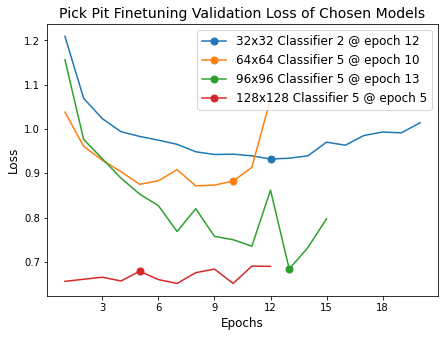

val_acc loaded
val_acc loaded
val_acc loaded
val_acc loaded


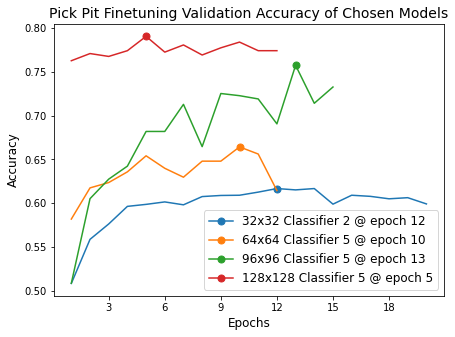

In [77]:
# Selected models for testing
# GB
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
dim_32_path = os.path.join(main_dir, 
    r'32x32\RC2-2FT all bs lr\Pick_2021_Model_RC2-2FT_dim32_bs4096_s5999_lr9e-05_epoch20_of_20')

dim_64_path = os.path.join(main_dir,
    r'64x64\Default classes\RC5-3FT all\Pick_2021_Model_RC5-3FT_dim64_bs1024_s5999_lr9e-05_epoch15_of_15')

dim_96_path = os.path.join(main_dir,
    r'96x96\aug\RC5-4FT all lr\Pick_2021_Model_RC5-4FT_dim96_bs512_s59_lr0.0001_epoch15_of_15')

dim_128_path = os.path.join(main_dir,
    r'128x128\RC5-4FT all lr\Pick_2021_Model_RC5-4FT_dim128_bs256_s199_lr3e-06_epoch12_of_12')

files_path = {'32x32 Classifier 2': dim_32_path, '64x64 Classifier 5': dim_64_path, 
              '96x96 Classifier 5': dim_96_path, '128x128 Classifier 5': dim_128_path}
marker_at = {'32x32 Classifier 2': [11], '64x64 Classifier 5': [9], '96x96 Classifier 5': [12], '128x128 Classifier 5': [4]}

# Plot validation accuracies and losses for selected models
fig, ax = plt.subplots(figsize = (7, 5))
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_losses')
    if dim == '64x64 Classifier 5':
        plt.plot(range(1, len(losses['val_losses'][:-3])+1), losses['val_losses'][:-3], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    else:
        plt.plot(range(1, len(losses['val_losses'])+1), losses['val_losses'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
plt.title('Pick Pit Finetuning Validation Loss of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show();  

fig, ax = plt.subplots(figsize = (7, 5))
for dim, file_path in files_path.items():
    losses = load_loss_acc(file_path, 'val_acc')
    if dim == '64x64 Classifier 5':
        plt.plot(range(1, len(losses['val_acc'][:-3])+1), losses['val_acc'][:-3], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    else:
        plt.plot(range(1, len(losses['val_acc'])+1), losses['val_acc'], marker = 'o', markersize = 7,
             markevery = [marker_at[dim][0]], label = '{} @ epoch {}'.format(dim, marker_at[dim][0]+1))
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Accuracy', fontsize = 12)
plt.title('Pick Pit Finetuning Validation Accuracy of Chosen Models', fontsize = 14)
plt.legend(fontsize = 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show(); 

***=========================================================================================================***

## Get Top k predictions and visualize incorrectly predicted samples

In [67]:
def visual_pred(data, labels, kprobs, kcls, num, seed, from_one = False, save = False):
    """
    Description:
        Visualize a specified number of predicted tiles for each ground truth class (randomly) with the correct labels 
        and top k predicted classes and their probabilities. Also saves all of the predictions.
        
    Args:
        data: Original data of incorrectly predicted tiles (torch tensor)
        labels: Ground truth labels of incorrectly predicted tiles (torch tensor)
        kprobs: Top k probabilities of incorrectly predicted tiles (torch tensor)
        kcls: Top k classes of incorrectly predicted tiles (torch tensor)  
        num: Number of tiles to display for each ground truth label (int)
        seed: Set torch seed for reproducibility of the tiles shown
        from_one: Adjust the labels to start from 1 (bool)
        save: Save all of the predictions (bool)

    Outputs:
        None
    
    """
    
    if from_one:
        labels, kcls = labels + 1, kcls + 1 # Change labels from [0, Class number) to [1, Class number]
    torch.manual_seed(seed) # Seed for consistency  
    units = labels.unique() # Number of units in ground truth label (torch tensor)
    
    # For each ground truth class, visualize a set number of tiles
    for unit in units:
        mask = labels == unit.item() 

        if torch.sum(mask).item() == 0: # If the labels don't contain a certain unit number, go on to the next one
            print('There are no unit {} in the labels'.format(unit.item()))
            continue            
        label, data_show, kcls_show, kprobs_show = labels[mask], data[mask], kcls[mask], kprobs[mask] # torch tensor [n, ]    
        indices = torch.randperm(label.shape[0])[:num] # Randomly get a number of indices to visualize for each class
        
        # Visualize selected predictions
        for ind in indices:
            plt.imshow(np.transpose(data_show[ind].byte().numpy(), (1, 2, 0))) # Show the image from np array
            plt.title('Ground Truth: Unit {}'.format(unit.item())) # Set the label class as title
            plt.axis('off')
            plt.show()
            print('Top {} Predictions with their probabilities'.format(kcls_show.shape[-1]))

            for x in range(kcls[mask][ind].shape[-1]):                
                print('Unit {}: {:.3f}'.format(kcls_show[ind, x].item(), kprobs_show[ind, x].numpy()), )
            print('')
        print('='*100)
        
        # Save all predictions
        if save:
            parent_path = os.path.join(main_dir, 'Predictions_{}_{}'.format(data_show[0].shape[1], dataset))
            if not os.path.exists(parent_path):
                os.makedirs(parent_path)                
            child_path = os.path.join(parent_path, str(unit.item())) # Folder for each ground truth unit label
            if not os.path.exists(child_path):
                os.mkdir(child_path)
            for p in range(data_show.shape[0]):
                img = Image.fromarray(np.transpose(data_show[p].byte().numpy(), (1, 2, 0))) # Required to save as .tif
                file_name = 'N' + str(p) # Adding a prefix to avoid identical file names
                for v in range(kcls[mask][p].shape[-1]): 
                    # file name is top k class + prob
                    file_name += '_' + str(kcls_show[p, v].item()) + '-' + '{:.2f}'.format(kprobs_show[p, v].numpy())
                file_name += '.tif' 
                img.save(os.path.join(child_path, file_name))                        

    return    

def topk_pred(data_name, label_name, model, k, orig_data_name = None, num = 0, seed = 1, save = True, from_one = False):
    """
    Description:
        Get top k predictions with their probabilities
        
    Args:
        data_name: File name of the preprocessed data (str)
        label_name: File name of the labels (str)
        model: Model to be used for prediction
        k: Number of classes to display
        orig_data_name: File name of the original data (str)        
        num: Number of tiles to display for each ground truth label (int)
        seed: Set torch seed for reproducibility of the tiles shown
        save: Save predictions (bool)
        from_one: Adjust the labels to start from 1 (bool)
            
    Outputs:
        wrongs: Original data of incorrectly predicted tiles (torch tensor)
        wrongs_labs: Ground truth labels of incorrectly predicted tiles (torch tensor)
        wrongs_kprobs: Top k probabilities of incorrectly predicted tiles (torch tensor)
        wrongs_kcls: Top k classes of incorrectly predicted tiles (torch tensor)  
    """
    
    # Load data and labels
    if orig_data_name is not None:
        orig_data, _ = data_load(df = os.path.join(main_dir, orig_data_name), verbose = False) # torch tensor [N, C, H, W]
    data, labels = data_load(df = os.path.join(main_dir, data_name), # torch tensor [N, C*, H*, W*] and [N,]
                        lf = os.path.join(main_dir, label_name), 
                        verbose = False)
    
    # Preprocess labels and optionally data if they are not preprocessed
    if 'feat' not in data_name:
        train_file = os.path.join(main_dir, 'train_tensors_{}.pt'.format(orig_data_name.split('_')[-1].split('.')[0]))
        data, labels = data_preproc(train_file, data, file_labels = labels)
    else:
        _, labels = data_preproc(file_labels = labels) # Labels [0, Class number)

    # Compute model predictions
    model.eval()
    pred = model(data).detach() # Original data and predictions have the exact same index order (see feats compute function)
    
    # Get probabilities of top k predictions using softmax
    topk_prob, topk_class = torch.topk(F.softmax(pred, dim = 1), k)
    mask = topk_class[:, 0] != labels # torch tensor [N*,] where N* = no. of incorrectly labelled samples
    wrongs = orig_data[mask] # torch tensor [N*, C, H, W] 
    wrongs_labs = labels[mask] # torch tensor [N*,] of [0, Class number)
    wrongs_kprobs = topk_prob[mask] # torch tensor [N*, k]
    wrongs_kcls = topk_class[mask] # torch tensor [N*, k]

    if num != 0 and type(num) != str:
        visual_pred(data = wrongs, 
                    labels = wrongs_labs,
                    kprobs = wrongs_kprobs,
                    kcls = wrongs_kcls,
                    num = num,
                    seed = seed,                    
                   from_one = from_one,
                   save = save)  
        
    return (wrongs, wrongs_labs, wrongs_kprobs, wrongs_kcls)

Data preprocessing complete 



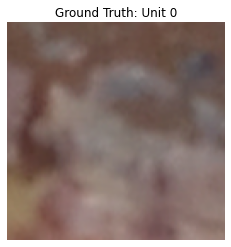

Top 3 Predictions with their probabilities
Unit 2: 0.629
Unit 0: 0.332
Unit 4: 0.023



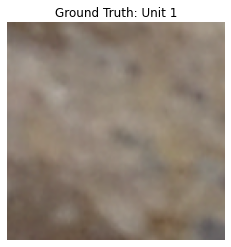

Top 3 Predictions with their probabilities
Unit 0: 0.497
Unit 1: 0.308
Unit 3: 0.099



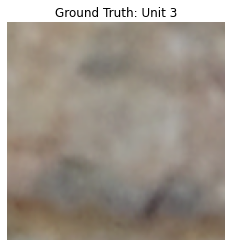

Top 3 Predictions with their probabilities
Unit 1: 0.383
Unit 3: 0.331
Unit 4: 0.178



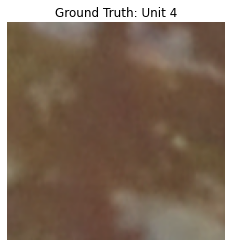

Top 3 Predictions with their probabilities
Unit 0: 0.591
Unit 4: 0.291
Unit 2: 0.102



In [95]:
# Change
params = 'Pick_2021_Model_RC5-2_dim128_bsNone_s5999_lr0.001_epoch190_of_200.pt' 
dataset = 'train'
num_class = 5
layer1_size = 1024 
layer2_size = 512
layer3_size = 512
layer4_size = 512
dim = int(params.split('_')[4][3:])


# net = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, params.split('_')[6][1:]) 
net = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, params.split('_')[6][1:])
# net = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, params.split('_')[6][1:]) 
# net = ResNet_Classifier_7(params.split('_')[3], layer1_size, layer2_size, layer3_size, layer4_size, num_class, params.split('_')[6][1:])
net.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
net.eval()
                    
topk_pred(data_name = '{}_resnet50_feat_tensors_{}.pt'.format(dataset, dim),
         label_name = '{}_tile_labels_tensors_{}.pt'.format(dataset, dim),
          model = net,
          k = 3, # top k predictions
          orig_data_name = '{}_tensors_{}.pt'.format(dataset, dim),
          num = 1, # num of predictions to show in cell output
          seed = 2, # seed for reproducibility of predictions displayed in cell output
          save = True, # save all predictions
         from_one = False) # Rearrange labels to be from 1

***=========================================================================================================***

## Feature extraction method: Test Data

Labels subtracted by 1
Data preprocessing complete 



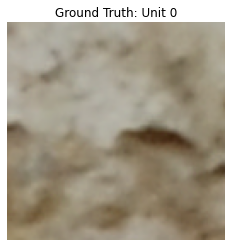

Top 3 Predictions with their probabilities
Unit 1: 0.736
Unit 0: 0.263
Unit 3: 0.000



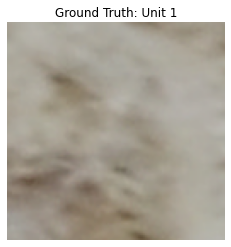

Top 3 Predictions with their probabilities
Unit 0: 0.808
Unit 1: 0.192
Unit 3: 0.000



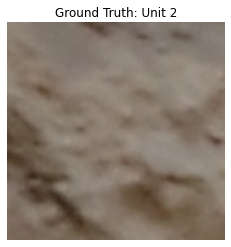

Top 3 Predictions with their probabilities
Unit 1: 0.876
Unit 3: 0.108
Unit 2: 0.015



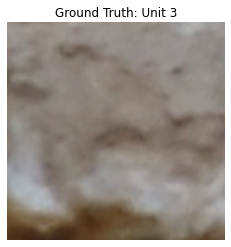

Top 3 Predictions with their probabilities
Unit 1: 0.998
Unit 3: 0.002
Unit 0: 0.000

Labels shape: torch.Size([660])
For model Top_2021_Model_RC7-2_dim128_bsNone_s99_lr0.001_epoch166_of_200.pt:
The test accuracy is 0.945
test_acc saved


['test_acc']

In [70]:
# Run models on test data
# params = 'Top_2021_Model_RC1-1_dim32_bsNone_s59_lr0.001_epoch84_of_90.pt'
# params = 'Top_2021_Model_RC1-5_dim64_bsNone_s599_lr0.001_epoch62_of_100.pt'
# params = 'Top_2021_Model_RC1-3_dim96_bsNone_s5999_lr0.001_epoch78_of_90.pt'
# params = 'Top_2021_Model_RC7-3_dim128_bsNone_s199_lr0.001_epoch119_of_140.pt'

# params = 'Pick_2021_Model_RC2-2_dim32_bsNone_s5999_lr0.001_epoch75_of_80.pt'
# params = 'Pick_2021_Model_RC5-3_dim64_bsNone_s5999_lr0.001_epoch84_of_100.pt'
# params = 'Pick_2021_Model_RC5-4_dim96_bsNone_s59_lr0.001_epoch146_of_150.pt'
params = 'Pick_2021_Model_RC5-4_dim128_bsNone_s199_lr0.001_epoch152_of_170.pt' 

dataset = 'test'
num_class = 4
layer1_size = 1024 
layer2_size = 1024
layer3_size = 1024
layer4_size = 512
dim = int(params.split('_')[4][3:])


# net = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, params.split('_')[6][1:]) 
# net = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, params.split('_')[6][1:])
# net = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, params.split('_')[6][1:]) 
net = ResNet_Classifier_7(params.split('_')[3], layer1_size, layer2_size, layer3_size, layer4_size, num_class, params.split('_')[6][1:])
net.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
net.eval()
                    
out = topk_pred(data_name = '{}_resnet50_feat_tensors_{}.pt'.format(dataset, dim),
         label_name = '{}_tile_labels_tensors_{}.pt'.format(dataset, dim),
          model = net,
          k = 3, # top k predictions
          orig_data_name = '{}_tensors_{}.pt'.format(dataset, dim),
          num = 1, # num of predictions to show in cell output
          seed = 2, # seed for reproducibility of predictions displayed in cell output
          save = True, # save all predictions
         from_one = False) # Rearrange labels to be from 1

# Get test accuracy
_, test_gt = data_load(lf = os.path.join(main_dir, '{}_tile_labels_tensors_{}.pt'.format(dataset, dim)), 
                       verbose = True)
test_acc = 1 - len(out[1])/test_gt.shape[0]
print('For model {}:'.format(params))
print('The test accuracy is {:.3f}'.format(test_acc))

# Save results
save_loss_acc(params.replace('.pt', ''), test_acc = [test_acc])

In [ ]:
# Plot test accuracies between different dims
# BM
dim_32_path = os.path.join(main_dir, 
    r'Top_2021_Model_RC1-1_dim32_bsNone_s59_lr0.001_epoch84_of_90')

dim_64_path = os.path.join(main_dir,
    r'Top_2021_Model_RC1-5_dim64_bsNone_s599_lr0.001_epoch62_of_100')

dim_96_path = os.path.join(main_dir,
    r'Top_2021_Model_RC1-3_dim96_bsNone_s5999_lr0.001_epoch78_of_90')

dim_128_path = os.path.join(main_dir,
    r'Top_2021_Model_RC7-3_dim128_bsNone_s199_lr0.001_epoch119_of_140')

files_path = {'32x32': dim_32_path, '64x64': dim_64_path, '96x96': dim_96_path, '128x128': dim_128_path}

BM_accs = {}
for dim, file_path in files_path.items():
    BM_accs[dim] = load_loss_acc(file_path, 'test_acc')['test_acc'][0]

plt.figure(figsize = (10, 6)) 
plt.bar(*zip(*BM_accs.items()))    
plt.xlabel('Tile Dimension (pixels)', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
# plt.yticks(np.arange(0, 1, step = 0.1))
plt.ylim(top = 1.0)
plt.title('Bald Mountain Top Pit Test Accuracy of Chosen Model', fontsize = 16)
plt.show();  

In [ ]:
# Plot test accuracies between different dims
# GB
dim_32_path = os.path.join(main_dir, 
    r'Pick_2021_Model_RC2-2_dim32_bsNone_s5999_lr0.001_epoch75_of_80')

dim_64_path = os.path.join(main_dir,
    r'Pick_2021_Model_RC5-3_dim64_bsNone_s5999_lr0.001_epoch84_of_100')

dim_96_path = os.path.join(main_dir,
    r'Pick_2021_Model_RC5-4_dim96_bsNone_s59_lr0.001_epoch146_of_150')

dim_128_path = os.path.join(main_dir,
    r'Pick_2021_Model_RC5-4_dim128_bsNone_s199_lr0.001_epoch152_of_170')

files_path = {'32x32': dim_32_path, '64x64': dim_64_path, '96x96': dim_96_path, '128x128': dim_128_path}

GB_accs = {}
for dim, file_path in files_path.items():
    GB_accs[dim] = load_loss_acc(file_path, 'test_acc')['test_acc'][0]

plt.figure(figsize = (10, 6)) 
plt.bar(*zip(*GB_accs.items()))    
plt.xlabel('Tile Dimension (pixels)', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
plt.ylim(top = 1.0)
# plt.yticks(np.arange(0, 1, step = 0.1))
plt.title('Gold Bar Pick Pit Test Accuracy of Chosen Models', fontsize = 16)
plt.show();  

## Fine-tuning method: Test Data

Mean values of the three channels are: tensor([138.7794, 127.2458, 109.5673])
Stdev values of the three channels are: tensor([27.5850, 31.1816, 33.4441])

Mean values of the three channels after input normalization are: tensor([-0.0075, -0.0013,  0.0094])
Stdev values of the three channels after input normalization are: tensor([0.9902, 0.9922, 0.9949])

Labels subtracted by 1
Data preprocessing complete 



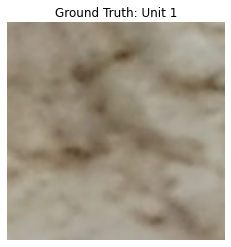

Top 3 Predictions with their probabilities
Unit 2: 0.859
Unit 1: 0.140
Unit 3: 0.001



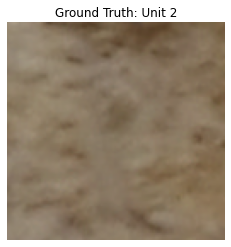

Top 3 Predictions with their probabilities
Unit 3: 0.967
Unit 2: 0.033
Unit 4: 0.000



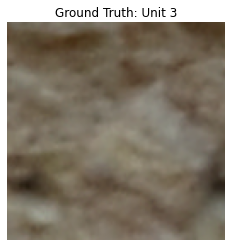

Top 3 Predictions with their probabilities
Unit 2: 0.773
Unit 3: 0.193
Unit 4: 0.025



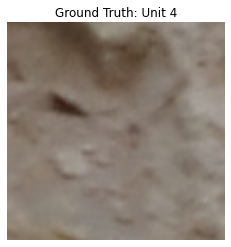

Top 3 Predictions with their probabilities
Unit 2: 0.968
Unit 4: 0.031
Unit 3: 0.001

Labels shape: torch.Size([660])
For model Top_2021_Model_RC7-3FT_dim128_bs256_s199_lr3e-05_epoch6_of_10.pt:
The test accuracy is 0.965
test_acc saved


['test_acc']

In [77]:
# Run models on test data
# params = 'Top_2021_Model_RC1-1FT_dim32_bs4096_s59_lr9e-05_epoch11_of_16.pt'
# params = 'Top_2021_Model_RC1-5FT_dim64_bs1024_s599_lr9e-05_epoch11_of_12.pt'
# params = 'Top_2021_Model_RC1-3FT_dim96_bs512_s5999_lr9e-05_epoch9_of_12.pt'
params = 'Top_2021_Model_RC7-3FT_dim128_bs256_s199_lr3e-05_epoch6_of_10.pt'

# params = 'Pick_2021_Model_RC2-2FT_dim32_bs4096_s5999_lr9e-05_epoch11_of_20.pt'
# params = 'Pick_2021_Model_RC5-3FT_dim64_bs1024_s5999_lr9e-05_epoch9_of_15.pt'
# params = 'Pick_2021_Model_RC5-4FT_dim96_bs512_s59_lr0.0001_epoch12_of_15.pt'
# params = 'Pick_2021_Model_RC5-4FT_dim128_bs256_s199_lr3e-06_epoch4_of_12.pt' 

dataset = 'test'
num_class = 4
layer1_size = 1024 
layer2_size = 1024
layer3_size = 1024
layer4_size = 512
dim = int(params.split('_')[4][3:])

# Setup finetuned model architecture 
net = resnet50(pretrained = False)
# Replace Resnet classifier with trained custom classifier
# net.fc = ResNet_Classifier_1(params.split('_')[3], layer1_size, layer2_size, num_class, params.split('_')[6][1:])  
# net.fc = ResNet_Classifier_2(params.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, params.split('_')[6][1:])      
# net.fc = ResNet_Classifier_5(params.split('_')[3], layer1_size, layer2_size, num_class, params.split('_')[6][1:])
net.fc = ResNet_Classifier_7(params.split('_')[3], layer1_size, layer2_size, layer3_size, layer4_size, num_class, params.split('_')[6][1:]) # 2 drop out
net.load_state_dict( torch.load(os.path.join(main_dir, params), map_location = torch.device('cpu')) )
net.eval()
                    
out = topk_pred(data_name = '{}_tensors_{}.pt'.format(dataset, dim),
         label_name = '{}_tile_labels_tensors_{}.pt'.format(dataset, dim),
          model = net,
          k = 3, # top k predictions
          orig_data_name = '{}_tensors_{}.pt'.format(dataset, dim),
          num = 1, # num of predictions to show in cell output
          seed = 2, # seed for reproducibility of predictions displayed in cell output
          save = True, # save all predictions
         from_one = True) # Rearrange labels to be from 1 (mainly for BM)

# Get test accuracy
_, test_gt = data_load(lf = os.path.join(main_dir, '{}_tile_labels_tensors_{}.pt'.format(dataset, dim)), 
                       verbose = True)
test_acc = 1 - len(out[1])/test_gt.shape[0]
print('For model {}:'.format(params))
print('The test accuracy is {:.3f}'.format(test_acc))

# Save results
save_loss_acc(params.replace('.pt', ''), test_acc = [test_acc])

test_acc loaded
test_acc loaded
test_acc loaded
test_acc loaded


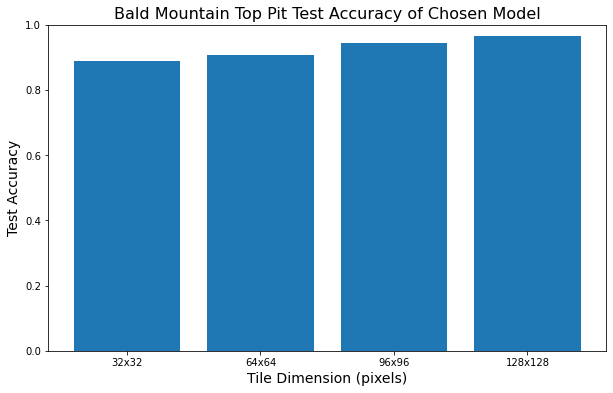

In [78]:
# Plot test accuracies between different dims
# BM
dim_32_path = os.path.join(main_dir, 
    r'Top_2021_Model_RC1-1FT_dim32_bs4096_s59_lr9e-05_epoch11_of_16')

dim_64_path = os.path.join(main_dir,
    r'Top_2021_Model_RC1-5FT_dim64_bs1024_s599_lr9e-05_epoch11_of_12')

dim_96_path = os.path.join(main_dir,
    r'Top_2021_Model_RC1-3FT_dim96_bs512_s5999_lr9e-05_epoch9_of_12')

dim_128_path = os.path.join(main_dir,
    r'Top_2021_Model_RC7-3FT_dim128_bs256_s199_lr3e-05_epoch6_of_10')

files_path = {'32x32': dim_32_path, '64x64': dim_64_path, '96x96': dim_96_path, '128x128': dim_128_path}

BM_accs = {}
for dim, file_path in files_path.items():
    BM_accs[dim] = load_loss_acc(file_path, 'test_acc')['test_acc'][0]

plt.figure(figsize = (10, 6)) 
plt.bar(*zip(*BM_accs.items()))    
plt.xlabel('Tile Dimension (pixels)', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
# plt.yticks(np.arange(0, 1, step = 0.1))
plt.ylim(top = 1.0)
plt.title('Bald Mountain Top Pit Test Accuracy of Chosen Model', fontsize = 16)
plt.show();  

test_acc loaded
test_acc loaded
test_acc loaded
test_acc loaded


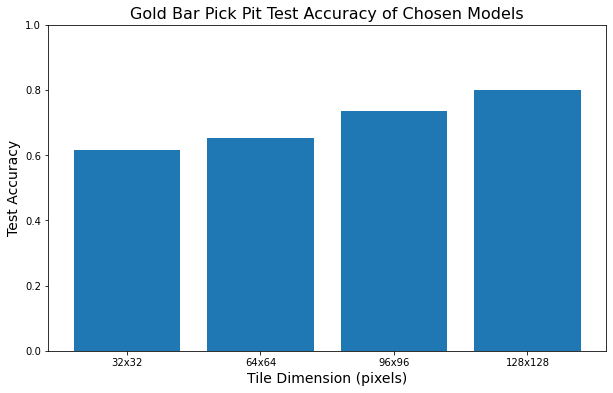

In [82]:
# Plot test accuracies between different dims
# GB
dim_32_path = os.path.join(main_dir, 
    r'Pick_2021_Model_RC2-2FT_dim32_bs4096_s5999_lr9e-05_epoch11_of_20')

dim_64_path = os.path.join(main_dir,
    r'Pick_2021_Model_RC5-3FT_dim64_bs1024_s5999_lr9e-05_epoch9_of_15')

dim_96_path = os.path.join(main_dir,
    r'Pick_2021_Model_RC5-4FT_dim96_bs512_s59_lr0.0001_epoch12_of_15')

dim_128_path = os.path.join(main_dir,
    r'Pick_2021_Model_RC5-4FT_dim128_bs256_s199_lr3e-06_epoch4_of_12')

files_path = {'32x32': dim_32_path, '64x64': dim_64_path, '96x96': dim_96_path, '128x128': dim_128_path}

GB_accs = {}
for dim, file_path in files_path.items():
    GB_accs[dim] = load_loss_acc(file_path, 'test_acc')['test_acc'][0]

plt.figure(figsize = (10, 6)) 
plt.bar(*zip(*GB_accs.items()))    
plt.xlabel('Tile Dimension (pixels)', fontsize = 14)
plt.ylabel('Test Accuracy', fontsize = 14)
plt.ylim(top = 1.0)
# plt.yticks(np.arange(0, 1, step = 0.1))
plt.title('Gold Bar Pick Pit Test Accuracy of Chosen Models', fontsize = 16)
plt.show();  

***=========================================================================================================***

## Map Generation

In [13]:
def other_metrics(y_true, y_pred, units, norms, pth):
    """
    Description: 
        Calculates other performance metrics other than accuracy such as precision, recall, F1, etc.
        Also creates confusion matrices.
    
    Args:
        y_true: The ground truth labels (Np array)
        y_pred: The predicted labels (Np array)
        units: The lith units (labels) (Np array)
        norms: Arguments for normalization parameter in confusion matrix (list of str)
        pth: Filename of model (str)
        
    Outputs:
        None      
        
    """
    assert y_true.shape == y_pred.shape, 'True and pred are not the same size.' # (N, )
    
    # Create confusion matrices
    for norm in norms:
        print('Norm:', norm)
        confu_mat = confusion_matrix(y_true, y_pred, labels = units, normalize = norm)
        disp = ConfusionMatrixDisplay(confusion_matrix = confu_mat, display_labels = units)
        disp.plot(cmap = 'Blues')
        plt.show()
        disp.figure_.savefig( os.path.join(main_dir, pth) + '_' + str(norm) + '_cm.jpg') 
    print('{} Confusion matrices saved'.format(len(norms)))
    
    # Compute precision, recall, F1, and support
    precision, recall, F1, support = precision_recall_fscore_support(y_true, y_pred, labels = units)
            
    # Save metrics to file 
    df = pd.DataFrame(data = [precision, recall, F1, support], 
                      index = ['precision', 'recall', 'F1', 'support'],
                     columns = units)
    if os.path.exists(os.path.join(main_dir, 'metrics.xlsx')):
        eng = 'openpyxl'
        mode = 'a'
        sheets = 'replace'
        print('Appending to existing metrics file')
    else:
        eng = None
        mode = 'w'    
        sheets = None
        print('Creating new metrics file')
        
    with pd.ExcelWriter(os.path.join(main_dir, 'metrics.xlsx'), 
                        engine = eng, mode = mode, if_sheet_exists = sheets) as writer:
        s_name = pth.split('\\')[-1].split('_')
        df.to_excel(writer, 
                    sheet_name = s_name[3] + s_name[4] + s_name[6])

    return

In [14]:
# Define a function to split the input raster into small tiles
def split_raster(ortho_file, split_rows, split_cols, ):
    ''' This function splits ONE input raster into small tiles (type: numpy ndarray)
    
    Description:
        
        The raster will be split into small tiles, where each tile will have a dimension of split_rows*split_cols.
        The right-most columns and the bottom-most rows will be omitted i.e., Floor Division will be used.
        The horizontal span will be num_cols // split_cols, and the vertical span will be num_rows // split_rows.
     
    Arguments:
        
        ortho_file: file name of orthomosaic (str)
        split_rows: the num of rows which the input raster will be split based on (each tile row will have this many pixels)
        split_cols: the num of cols which the input raster will be split based on (each tile col will have this many pixels)
        
    Returns:
        
        raster_data_dict: a dictionary containing the tile data and the image coordinate of the upper left corner of the tile
                          {"number_of_tiles"} -- a scalar that records how many tiles have been generated
                          {<tile index>} -- every tile index will have its sub-dictionary which includes:
                                         -- {'data'}: the splited raster data
                                         -- {'coordinate'}: the image plane coordinate of the upper left corner of the tile
        
    
    Author: Miller Tang (modified by Peng Yang)
    Creation Date: June-06-2020
    Previous Edit: July-27-2022
    '''
    
    # Step 0. Load raster
    import cv2
    in_raster = cv2.imread(ortho_file)
    in_raster = in_raster[...,::-1]

    print(in_raster.shape)
    print(type(in_raster))
    
    ## Step 1. Check the input raster and raise exception if it is not fulfilling the requirements
    if in_raster is None:
        raise Exception('The input is None. The input should be a raster with three channels.')
    
    # Determine the dimension/shape of the input raster
    d1, d2, d3 = in_raster.shape
    
    # Check whether the input raster is a three-channels raster data with either a channel-first or channel-last shape
    # If the raster is a channel-first raster, transpose the raster into a channel last format
    if d1 == 3:
        print("The input is a channel first raster array.")
        num_rows = d2
        num_cols = d3
        num_bands = d1
        
    elif d3 == 3:
        print("The input is a channel last raster array. \
Since we are using PyTorch models, we will convert it into channel-first raster.")
        num_rows = d1
        num_cols = d2
        num_bands = d3
        in_raster = in_raster.transpose(2,0,1)
    else:
        raise Exception("The input is neither a channel-first, \
nor a channel-last FOUR channels raster. Please check the input again.")
    del d1,d2,d3
    
    # Check if the input raster can be split into smaller tiles
    if (num_rows < split_rows): 
        raise Exception("The number of ROWS of the input raster, {}, \
is smaller than the tile size to be split into, {}.".format(num_rows, split_rows))
    elif (num_cols < split_cols):
        raise Exception("The number of COLS of the input raster, {}, \
is smaller than the tile size to be split into, {}.".format(num_cols, split_cols))
    
    ## Step 2: Determine how many tiles are in the horizontal and vertical directions
    tiles_hor = num_cols // split_cols # Horizontal span
    tiles_ver = num_rows // split_rows # Vertical span
    
    ## Step 3: Define a dictionary to store the tile data and the image plane location of the tile
    raster_data_dict = {}
    
    key_idx = 0 # Define a counter to be the key for each tile
    total_tiles = tiles_hor * tiles_ver # This is how many tiles will be generated
    
    raster_data_dict["number_of_tiles"] = total_tiles
    
    ## Step 4: Split the raster into small tiles and store them into a dictionary
    # Loop through the input raster to split it
    for i in range(tiles_ver): # First layer loop to loop throught the vertical direction
        for j in range(tiles_hor): # Second layer loop to loop throught the horizontal direction
            
            # Every key will have a sub-dictionary to record the data and the image plane coordinate of the upper left corner
            raster_data_dict[key_idx] = {}
            
            # Record the data into the corresponding sub-dictionary
            raster_data_dict[key_idx]['data'] = in_raster[:,i*split_rows:(i+1)*split_rows,j*split_cols:(j+1)*split_cols]
            raster_data_dict[key_idx]['coordinate'] = [i*split_rows, j*split_cols] # Coordinate of the upper left corner
            
            key_idx = key_idx + 1
                                                          
    # End of the two for loops to split data
    
    print("The data have been split and stored in the output.")
    
    return raster_data_dict

In [15]:
def map_generation(raster_data_dict, label_data, model, model_file, train_file, b_size = None, transfer_model = None):
    """    
    Description:    
        The model will take each orthomosaic tile and output a class label, and each orthomosaic tile will be coloured
        based on the class label
     
    Arguments:
        
        raster_data_dict: a dictionary contains the tile data and the image coordinate of the upper left corner of the tile
                          {"number_of_tiles"} -- a scalar that records how many tiles have been generated
                          {<tile index>} -- every tile index will have its sub-dictionary which includes:
                                         -- {'data'}: the splited raster data
                                         -- {'coordinate'}: the image plane coordinate of the upper left corner of the tile
        
        label_data: The labels corresponding to the orthomosaic (torch tensor)
        model: The trained model architecture
        model_file: The file name of the chosen (trained) model used for mask prediction (str)
        train_file: The file name of the training data (str)
        b_size: Batch size for transfer learning model feature computation (int)
        transfer_model: The transfer learning model used for creating the model input (feature extractor)
    
    Returns:
        
        orth_map: the generated map
        
    
    Author: Miller Tang (Modified by Peng Yang)
    Creation Date: June-06-2020
    Previous Edit: Oct-14-2022
    
    """
    
    ## Step 1: Extract the necessary variable values from the dictionary
    num_tiles = raster_data_dict['number_of_tiles']
    num_bands, split_rows, split_cols = raster_data_dict[0]['data'].shape
    end_coor_row, end_coor_col = raster_data_dict[num_tiles-1]['coordinate']
    end_coor_row += split_rows
    end_coor_col += split_cols
    
    ## Step 2: Loop through all the stored splitted-raster data inside the dictionary and make prediction using the model
    
    # Normalize the splitted-raster data by training data mean and std. dev.
    data_arr = np.asarray([raster_data_dict[idx]['data'] for idx in list(raster_data_dict.keys())[1:]]) # Np array [N, 3, H, W]
    data_arr = torch.tensor(data_arr).float()
    data_arr, _ = data_preproc(train_file, data_arr, None) # torch tensor [N, 3, H, W]
    
    # Extract features or load already extracted ones
    if transfer_model is not None:
        if os.path.exists((os.path.join(main_dir, model_file + '_map_feats.pt'))):
            data_arr = torch.load(os.path.join(main_dir, model_file + '_map_feats.pt'))
        else:           
            print('Computing features...')
            if b_size is None:
                raise Exception('b_size required')
            data_arr = transfer_model_feats(transfer_model, 
                                                 data_arr, 
                                                 save = False,
                                                 prefix = '',
                                                 b_size = b_size) 
            torch.save(data_arr, os.path.join(main_dir, model_file + '_map_feats.pt'))
    
    # Using an np array to store the model outputs    
    model.load_state_dict( torch.load(os.path.join(main_dir, model_file + '.pt'), 
                                                map_location = torch.device('cpu')) ) # Load model to CPU
    model.eval() # Set the model to evaluation mode
    pred_arr = []
    
    # Allocate an empty mask space for the final map output and map of mislabelled predictions
    orth_map = np.ones( (end_coor_row, end_coor_col) ) * (15) # A random initialization value
    agree_map = np.ones( (end_coor_row, end_coor_col) ) * (10) # A random initialization value
    
    for idx in list(raster_data_dict.keys())[1:]: # Can change this loop to a torch DataLoader to allow faster batch computing
        pred = model(data_arr[idx][None,...]).detach().cpu() # torch tensor [N, C]
        pred_arr.append( torch.max(pred, 1)[1].numpy() ) # Labels from [0, C) where C = class number
        if (idx+1) % 2000 == 0:
            print("Computed {} tiles".format(idx+1))
    pred_arr = np.asarray(pred_arr).squeeze() # Np array [N, ]
    if 'Top' in model_file:
        pred_arr += 1 # Np array [N, ] where labels are now [1, C] 
    labels = len(np.unique(pred_arr))
        
    # Create map of agreements (tile-wise) of # Np array [N, ] True's and False's
    if type(label_data) == torch.Tensor:
        label_data = label_data.numpy()
    if label_data.ndim == 2:
        label_data = label_data.squeeze() # np array [N,]
    agree_arr = pred_arr == label_data # Label numbering between the two np arrays should be the same

    ## Step 3: Create the mask/map
    if 'Top' in model_file:
        clr_lib = ['darkgoldenrod', 'beige', 'brown', 'gray'] # Top Pit
    elif 'Pick' in model_file:
        clr_lib = ['silver', 'darkgoldenrod', 'red', 'blue', 'yellow'] # Pick Pit
    
    # Create an empty figure
    plt.figure(figsize = (15, 15))
    cmap = colors.ListedColormap(clr_lib[:labels]) 
    if 'Top' in model_file:
        bounds = [-0.5 + i for i in range(1, labels + 2)] 
    elif 'Pick' in model_file:
        bounds = [-0.5 + i for i in range(0, labels + 1)] # Separate one to ensure correct colours displayed

#     cmap = colors.ListedColormap(clr_lib[:labels]+['white'])
#     bounds = [-0.5 + i for i in range(labels + 2)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    fig = plt.imshow(orth_map, cmap = cmap, norm = norm)
    time.sleep(2) # Unit: [sec]    
    
    # Loop through the predictions to create the mask/map.
    for key_idx in list(raster_data_dict.keys())[1:]:
        coor_row, coor_col = raster_data_dict[key_idx]['coordinate'] # Extract the coordinate of the upper left corner
        
        # Update the map values by using the predicted mask
        orth_map[coor_row: (coor_row + split_rows), coor_col: (coor_col + split_cols)] = \
        pred_arr[key_idx]*np.ones((split_rows, split_cols)) # [H, W]
        
        agree_map[coor_row: (coor_row + split_rows), coor_col: (coor_col + split_cols)] = \
        agree_arr[key_idx]*np.ones((split_rows, split_cols)) # [H, W]
        
        # Step 3: Showing/plotting the update tile by tile
        # Update the figure every once in a while
        if (key_idx+1) % 800 == 0:
            
            clear_output(wait = True)
        
            # Show the map
            plt.figure(figsize = (15, 15))
            plt.imshow(orth_map, cmap = cmap, norm = norm)
            plt.axis('off')        
            plt.show()
            
            # Add a small delay after each iteration for image to show
            #time.sleep(0.4) # Unit: [sec]
            #clear_output(wait=True)
    
    # Ending the for loop for map creation
    clear_output(wait = True)
    plt.figure(figsize = (15, 15))
    plt.imshow(orth_map, cmap = cmap, norm = norm)
    for l, c in zip(np.unique(pred_arr), clr_lib):
        print('Label {} is colour {}'.format(l, c))

    # Save the map 
    plt.imsave("{}_map.jpg".format(model_file), orth_map, cmap = cmap)
    plt.imsave("{}_agreemap.jpg".format(model_file), agree_map, cmap = 'Greys') # White = disagree
#     np.save("{}_array".format(model_file), orth_map)
    plt.axis('off')        
    plt.show()    
        
    # Calculate quantitative metrics
    other_metrics(y_true = label_data, 
                  y_pred = pred_arr, 
                  units = np.unique(label_data), 
                  norms = ['true', 'pred', 'all', None], # Scikit-learn normalization options
                  pth = model_file)

    return orth_map  

In [53]:
# Change orthomosaic into tiles
# 2021_GB_Pick_E_Wall_orthomosaic_clipped_top.tif
# 2021_BM_Top_orthomosaic_sample_clipped.tif
# 2021_GB_Pick_E_Wall_orthomosaic_clipped_top.png
# 2021_BM_Top_orthomosaic_sample_clipped.png


# ortho_dir = os.path.dirname(os.path.dirname(os.getcwd()))
# ortho_f = os.path.join(ortho_dir, 'Orthomosaics', '2021_BM_Top_orthomosaic_sample_clipped.tif')
if mine_site == 'BM':
    ortho_f = os.path.join(r'D:\PYang\BM_GB_21\Orthomosaics', '2021_BM_Top_orthomosaic_sample_clipped.tif')
    lab_ortho_f = os.path.join(main_dir, '2021_BM_Top_orthomosaic_sample_clipped.png')
elif mine_site == 'GB':
    ortho_f = os.path.join(r'D:\PYang\BM_GB_21\Orthomosaics', '2021_GB_Pick_E_Wall_orthomosaic_clipped_top.tif')
    lab_ortho_f = os.path.join(main_dir, '2021_GB_Pick_E_Wall_orthomosaic_clipped_top.png')
row_dim = 128
col_dim = 128
out_ortho = split_raster(ortho_f, row_dim, col_dim)
out_labels = split_raster(lab_ortho_f, row_dim, col_dim)

data = []
labels = []
for i in list(out_labels.keys())[1:]:
    data.append(out_ortho[i]['data'])
    labels.append(out_labels[i]['data'][0]) # Just use 1 channel since all 3 are the same

data, labels = tile_label(data_f = torch.from_numpy(np.array(data)),
          label_f = torch.from_numpy(np.array(labels)),
          method = 'pixel majority',
          change = 1,
          value = 2,
          save = False)

(3371, 12118, 3)
<class 'numpy.ndarray'>
The input is a channel last raster array. Since we are using PyTorch models, we will convert it into channel-first raster.
The data have been split and stored in the output.
(3371, 12118, 3)
<class 'numpy.ndarray'>
The input is a channel last raster array. Since we are using PyTorch models, we will convert it into channel-first raster.
The data have been split and stored in the output.
Label classes before: tensor([0, 1, 2, 3, 4, 5], dtype=torch.uint8)
Labels after: tensor([0, 2, 3, 4, 5], dtype=torch.uint8)
Labels after sequencing from 1: tensor([0, 1, 2, 3, 4], dtype=torch.uint8)
tile labels shape:  torch.Size([2444, 1])


In [54]:
# Inputs for map generation
###############################################################################################################################
finetune = True
model_file = 'Pick_2021_Model_RC5-4FT_dim128_bs256_s199_lr3e-06_epoch4_of_12'
layer1_size = 1024
layer2_size = 512
# layer3_size = 512
# layer4_size = 512
num_class = 5
b_size = 4
model = ResNet_Classifier_1(model_file.split('_')[3], layer1_size, layer2_size, num_class, model_file.split('_')[6][1:])
#     model = ResNet_Classifier_7(model_file.split('_')[3], layer1_size, layer2_size, layer3_size,
    #                             layer4_size, num_class, model_file.split('_')[6][1:])
    # model = ResNet_Classifier_5(model_file.split('_')[3], layer1_size, layer2_size, num_class, model_file.split('_')[6][1:])
    # model = ResNet_Classifier_2(model_file.split('_')[3], layer1_size, layer2_size, layer3_size,
    #                             num_class, model_file.split('_')[6][1:])
###############################################################################################################################

train_file = os.path.join(main_dir, 'train_tensors_{}.pt'.format(row_dim))
if finetune:
    # Setup finetuned model architecture 
    model = resnet50(pretrained = False)
    # Replace Resnet classifier with trained custom classifier
#     model.fc = ResNet_Classifier_1(model_file.split('_')[3], layer1_size, layer2_size, num_class, model_file.split('_')[6][1:])  
#     model.fc = ResNet_Classifier_2(model_file.split('_')[3], layer1_size, layer2_size, layer3_size, num_class, model_file.split('_')[6][1:])      
    model.fc = ResNet_Classifier_5(model_file.split('_')[3], layer1_size, layer2_size, num_class, model_file.split('_')[6][1:])
    #     model.fc = ResNet_Classifier_7(model_file.split('_')[3], layer1_size, layer2_size, layer3_size, layer4_size, num_class, model_file.split('_')[6][1:]) # 2 drop out
    transfer = None 
else:
    transfer = torch.nn.Sequential(*(list( resnet50(pretrained = True).children() )[:-1]))


Label 0 is colour silver
Label 1 is colour darkgoldenrod
Label 2 is colour red
Label 3 is colour blue
Label 4 is colour yellow


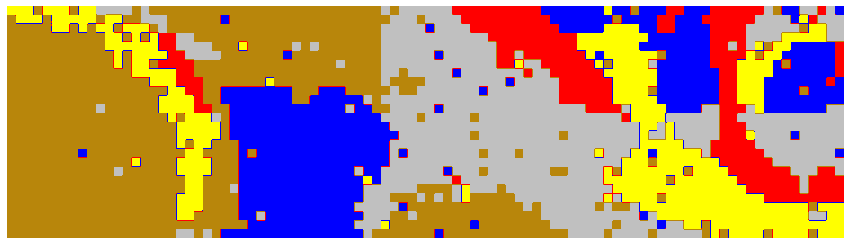

Norm: true


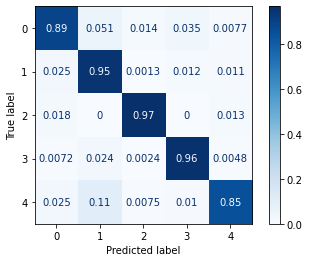

Norm: pred


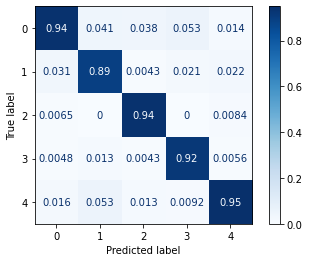

Norm: all


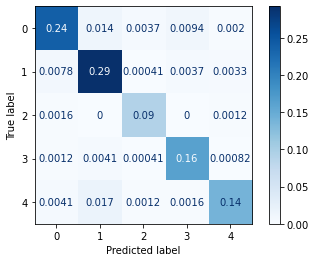

Norm: None


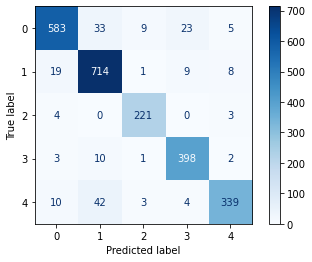

4 Confusion matrices saved
Appending to existing metrics file
Total run-time: 119.84853887557983s


In [55]:
start = time.time()
orth_map = map_generation(raster_data_dict = out_ortho, 
                          label_data = labels,
                           model = model, 
                           model_file = os.path.join(main_dir, model_file), 
                           train_file = train_file, 
                           b_size = b_size,
                           transfer_model = transfer)
print('Total run-time: {}s'.format(time.time() - start))